## **PSMDSBE 102 / Special Topics in Data Science**

### PILLAZO, JOHNNY BOY G.

# HOA 1.1 - MLOps Design

# HOA 1.2 - Data Preparation to Distribution 

In [ ]:
# initializes Ray

In [27]:
ray.shutdown()

In [1]:
import ray

# Initialize Ray
if ray.is_initialized():
    ray.shutdown()

ray.init()

2025-05-24 02:53:05,850	INFO worker.py:1633 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


Python version:,3.10.11
Ray version:,2.7.0
Dashboard:,http://127.0.0.1:8265


In [2]:
ray.cluster_resources()

{'memory': 788201472.0,
 'object_store_memory': 394100736.0,
 'node:127.0.0.1': 1.0,
 'node:__internal_head__': 1.0,
 'CPU': 8.0}

In [3]:
num_workers = 14  # 16 CPU - 2 (head node + background)
resources_per_worker = {"CPU": 1, "GPU": 0}  # Allocate CPU per worker

In [4]:
# Data Preparation

In [5]:
import pandas as pd

# Data ingestion
DATASET_LOC = "https://cs.calvin.edu/courses/ds/562/12deployment/example/data/dataset.csv"
df = pd.read_csv(DATASET_LOC)
df.head()

,id,created_on,title,description,tag,text
0,6,2020-02-20 06:43:18,Comparison between YOLO and RCNN on real world...,Bringing theory to experiment is cool. We can ...,computer-vision,comparison yolo rcnn real world videos bringin...
1,7,2020-02-20 06:47:21,"Show, Infer & Tell: Contextual Inference for C...",The beauty of the work lies in the way it arch...,computer-vision,show infer tell contextual inference creative ...
2,9,2020-02-24 16:24:45,Awesome Graph Classification,"A collection of important graph embedding, cla...",other,awesome graph classification collection import...
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...,other,awesome monte carlo tree search curated list m...
4,25,2020-03-07 23:04:31,AttentionWalk,"A PyTorch Implementation of ""Watch Your Step: ...",other,attentionwalk pytorch implementation watch ste...


In [6]:
from sklearn.model_selection import train_test_split

# Value counts
df.tag.value_counts()

tag
natural-language-processing    310
computer-vision                285
other                          106
mlops                           63
Name: count, dtype: int64

In [7]:
# Split dataset
test_size = 0.2
train_df, val_df = train_test_split(df, stratify=df.tag, test_size=test_size, random_state=1234)

In [8]:
# Train value counts
train_df.tag.value_counts()

tag
natural-language-processing    248
computer-vision                228
other                           85
mlops                           50
Name: count, dtype: int64

In [9]:
# Validation (adjusted) value counts
val_df.tag.value_counts() * int((1-test_size) / test_size)

tag
natural-language-processing    248
computer-vision                228
other                           84
mlops                           52
Name: count, dtype: int64

In [10]:
# Exploratory data analysis (EDA)

In [11]:
from collections import Counter
# Most common tags
all_tags = Counter(df.tag)
all_tags.most_common()

[('natural-language-processing', 310),
 ('computer-vision', 285),
 ('other', 106),
 ('mlops', 63)]

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

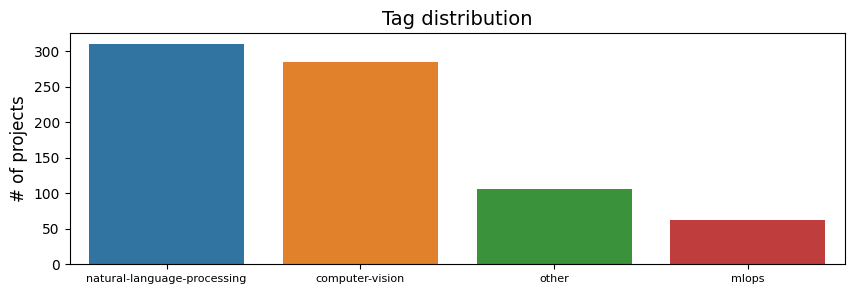

In [13]:
# Plot tag frequencies
tags, tag_counts = zip(*all_tags.most_common())
plt.figure(figsize=(10, 3))
ax = sns.barplot(x=list(tags), y=list(tag_counts))
ax.set_xticklabels(tags, rotation=0, fontsize=8)
plt.title("Tag distribution", fontsize=14)
plt.ylabel("# of projects", fontsize=12)
plt.show()

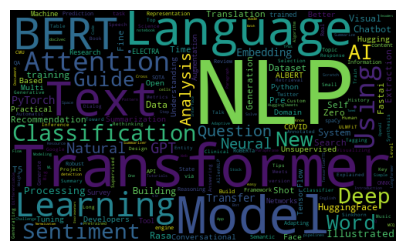

In [14]:
# Most frequent tokens for each tag
tag="natural-language-processing"
plt.figure(figsize=(10, 3))
subset = df[df.tag==tag]
text = subset.title.values
cloud = WordCloud(
    stopwords=STOPWORDS, background_color="black", collocations=False,
    width=500, height=300).generate(" ".join(text))
plt.axis("off")
plt.imshow(cloud)

In [15]:
# Data preprocessing 

In [16]:
import nltk
from nltk.corpus import stopwords
#nltk.download("stopwords")

In [17]:
import re

In [18]:
STOPWORDS = stopwords.words("english")

def clean_text(text, stopwords=STOPWORDS):
    """Clean raw text string."""
    # Lower
    text = text.lower()

    # Remove stopwords
    pattern = re.compile(r'\b(' + r"|".join(stopwords) + r")\b\s*")
    text = pattern.sub('', text)

    # Spacing and filters
    text = re.sub(r"([!\"'#$%&()*\+,-./:;<=>?@\\\[\]^_`{|}~])", r" \1 ", text)  # add spacing
    text = re.sub("[^A-Za-z0-9]+", " ", text)  # remove non alphanumeric chars
    text = re.sub(" +", " ", text)  # remove multiple spaces
    text = text.strip()  # strip white space at the ends
    text = re.sub(r"http\S+", "", text)  #  remove links

    return text

In [19]:
# Apply to dataframe
original_df = df.copy()
df.text = df.text.apply(clean_text)
print (f"{original_df.text.values[0]}\n{df.text.values[0]}")

comparison yolo rcnn real world videos bringing theory experiment cool easily train models colab find results minutes
comparison yolo rcnn real world videos bringing theory experiment cool easily train models colab find results minutes


In [20]:
# DataFrame cleanup
df = df.drop(columns=["id", "created_on", "title", "description"], errors="ignore")  # drop cols
df = df.dropna(subset=["tag"])  # drop nulls
df = df[["text", "tag"]]  # rearrange cols
df.head()

,text,tag
0,comparison yolo rcnn real world videos bringin...,computer-vision
1,show infer tell contextual inference creative ...,computer-vision
2,awesome graph classification collection import...,other
3,awesome monte carlo tree search curated list m...,other
4,attentionwalk pytorch implementation watch ste...,other


In [21]:
# Label to index
tags = train_df.tag.unique().tolist()
num_classes = len(tags)
class_to_index = {tag: i for i, tag in enumerate(tags)}
class_to_index

{'mlops': 0,
 'natural-language-processing': 1,
 'computer-vision': 2,
 'other': 3}

In [22]:
def decode(indices, index_to_class):
    return [index_to_class[index] for index in indices]

df["tag_index"] = df["tag"].map(class_to_index)
index_to_class = {v:k for k, v in class_to_index.items()}
#decode(df.head()["tag"].values, index_to_class=index_to_class)
decode(df.head()["tag_index"].values, index_to_class=index_to_class)

['computer-vision', 'computer-vision', 'other', 'other', 'other']

In [23]:
import numpy as np
from transformers import BertTokenizer

In [24]:
# Bert tokenizer
tokenizer = BertTokenizer.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
text = "Transfer learning with transformers for text classification."
encoded_inputs = tokenizer([text], return_tensors="np", padding="longest")  # pad to longest item in batch
print ("input_ids:", encoded_inputs["input_ids"])
print ("attention_mask:", encoded_inputs["attention_mask"])
print (tokenizer.decode(encoded_inputs["input_ids"][0]))

C:\Users\Administrator\Desktop\Special Topics in Data Science\PSMDSBE102\venv\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


vocab.txt:   0%|          | 0.00/228k [00:00<?, ?B/s]

C:\Users\Administrator\Desktop\Special Topics in Data Science\PSMDSBE102\venv\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Administrator\.cache\huggingface\hub\models--allenai--scibert_scivocab_uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

input_ids: [[  102  2268  1904   190 29155   168  3267  2998   205   103]]
attention_mask: [[1 1 1 1 1 1 1 1 1 1]]
[CLS] transfer learning with transformers for text classification. [SEP]


# HOA 2.1 - Distributed Training & Observation

## OPENAI API

In [25]:
# Data ingestion
ds = ray.data.read_csv(DATASET_LOC)
ds = ds.random_shuffle(seed=1234)
ds.take(1)

RayTaskError(ModuleNotFoundError): [36mray::_get_reader()[39m (pid=7652, ip=127.0.0.1)
  File "python\ray\_raylet.pyx", line 1616, in ray._raylet.execute_task
  File "C:\Users\Administrator\Desktop\Special Topics in Data Science\PSMDSBE102\venv\lib\site-packages\ray\data\read_api.py", line 2348, in _get_reader
    reader = ds.create_reader(**kwargs)
  File "C:\Users\Administrator\Desktop\Special Topics in Data Science\PSMDSBE102\venv\lib\site-packages\ray\data\datasource\file_based_datasource.py", line 256, in create_reader
    return _FileBasedDatasourceReader(self, **kwargs)
  File "C:\Users\Administrator\Desktop\Special Topics in Data Science\PSMDSBE102\venv\lib\site-packages\ray\data\datasource\file_based_datasource.py", line 476, in __init__
    _check_pyarrow_version()
  File "C:\Users\Administrator\Desktop\Special Topics in Data Science\PSMDSBE102\venv\lib\site-packages\ray\data\_internal\util.py", line 78, in _check_pyarrow_version
    from pkg_resources._vendor.packaging.version import parse as parse_version
ModuleNotFoundError: No module named 'pkg_resources._vendor'

In [ ]:
#ray.shutdown()

In [ ]:
#import ray

# Initialize Ray
#if ray.is_initialized():
    #ray.shutdown()

#ray.init()

In [ ]:
# Data ingestion
ds = ray.data.read_csv(paths=DATASET_LOC)
ds = ds.random_shuffle(seed=1234)
ds.take(1)

In [ ]:
# Split dataset
test_size = 0.2
#train_ds, val_ds = train_test_split(ds, test_size=test_size, stratify=["tag"])
train_ds, val_ds = ds.train_test_split(test_size = test_size)

In [ ]:
!pip install openai==0.28
import openai

In [18]:
openai.api_key = "-----"

In [4]:
import pandas as pd

# Load training data
DATASET_LOC = "dataset.csv"
train_df = pd.read_csv(DATASET_LOC)
train_df.head()

,id,created_on,title,description,tag
0,6,2020-02-20 06:43:18,Comparison between YOLO and RCNN on real world...,Bringing theory to experiment is cool. We can ...,computer-vision
1,7,2020-02-20 06:47:21,"Show, Infer & Tell: Contextual Inference for C...",The beauty of the work lies in the way it arch...,computer-vision
2,9,2020-02-24 16:24:45,Awesome Graph Classification,"A collection of important graph embedding, cla...",other
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...,other
4,25,2020-03-07 23:04:31,AttentionWalk,"A PyTorch Implementation of ""Watch Your Step: ...",other


In [10]:
# Unique labels
tags = train_df.tag.unique().tolist()
tags

['computer-vision', 'other', 'natural-language-processing', 'mlops']

In [11]:
# Load inference dataset
HOLDOUT_LOC = "holdout.csv"
test_df = pd.read_csv(HOLDOUT_LOC)
test_df.head()

,id,created_on,title,description,tag
0,19,2020-03-03 13:54:31,Diffusion to Vector,Reference implementation of Diffusion2Vec (Com...,other
1,26,2020-03-07 23:11:58,Graph Wavelet Neural Network,"A PyTorch implementation of ""Graph Wavelet Neu...",other
2,44,2020-03-08 00:32:58,Capsule Graph Neural Network,"A PyTorch implementation of ""Capsule Graph Neu...",other
3,80,2020-03-20 05:59:32,NeRF: Neural Radiance Fields,Representing scenes as neural radiance fields ...,computer-vision
4,84,2020-03-20 15:18:43,Mention Classifier,Category prediction model\nThis repo contains ...,natural-language-processing


In [12]:
import json
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
from sklearn.metrics import precision_recall_fscore_support
import time
from tqdm import tqdm

In [19]:
system_content = "You only answer in rhymes."
user_content = "How are you?"
assistant_content = ""

messages = [
    {"role": "system", "content": system_content},
    {"role": "user", "content": user_content},
    {"role": "assistant", "content": assistant_content}
]

response = openai.ChatCompletion.create(
    model="gpt-3.5-turbo",  # You can also use "gpt-4" if available
    messages=messages,
    max_tokens=100,
    temperature=0.7
)

# Extract and print the response content
reply = response["choices"][0]["message"]["content"]
print(reply)

I'm doing fine, feeling quite divine, thank you for asking, your kindness is everlasting.


In [21]:
def get_tag(model, system_content="", assistant_content="", user_content=""):
    try:
        # Get response from OpenAI
        response = openai.ChatCompletion.create(
            model=model,
            messages=[
                {"role": "system", "content": system_content},
                {"role": "assistant", "content": assistant_content},
                {"role": "user", "content": user_content},
            ],
        )
        predicted_tag = response.to_dict()["choices"][0].to_dict()["message"]["content"]
        return predicted_tag

    except (openai.error.ServiceUnavailableError, openai.error.APIError) as e:
        return None

# Get tag
model = "gpt-3.5-turbo"
system_context = f"""
    You are a NLP prediction service that predicts the label given an input's title and description.
    You must choose between one of the following labels for each input: {tags}.
    Only respond with the label name and nothing else.
    """
assistant_content = ""
user_context = "Transfer learning with transformers: Using transformers for transfer learning on text classification tasks."
tag = get_tag(model=model, system_content=system_context, assistant_content=assistant_content, user_content=user_context)
print (tag)

natural-language-processing


In [23]:
# List of dicts w/ {title, description} (just the first 3 samples for now)
samples = test_df[["title", "description"]].to_dict(orient="records")[:3]
samples

def get_predictions(inputs, model, system_content, assistant_content=""):
    y_pred = []
    for item in tqdm(inputs):
        # Convert item dict to string
        user_content = str(item)

        # Get prediction
        predicted_tag = get_tag(
            model=model, system_content=system_content,
            assistant_content=assistant_content, user_content=user_content)

        # If error, try again after pause (repeatedly until success)
        while predicted_tag is None:
            time.sleep(30)  # could also do exponential backoff
            predicted_tag = get_tag(
                model=model, 
    system_content=system_content,
    assistant_content=assistant_content, 
    user_content=user_content
)

        # Add to list of predictions
        y_pred.append(predicted_tag)

    return y_pred

# Get predictions for a list of inputs
get_predictions(inputs=samples, model=model, system_content=system_context)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.62it/s]


['natural-language-processing', 'computer-vision', 'computer-vision']

In [24]:
def clean_predictions(y_pred, tags, default="other"):
    for i, item in enumerate(y_pred):
        if item not in tags:  # hallucinations
            y_pred[i] = default
        if item.startswith("'") and item.endswith("'"):  # GPT 4 likes to places quotes
            y_pred[i] = item[1:-1]
    return y_pred

In [25]:
def plot_tag_dist(y_true, y_pred):
    # Distribution of tags
    true_tag_freq = dict(Counter(y_true))
    pred_tag_freq = dict(Counter(y_pred))
    df_true = pd.DataFrame({"tag": list(true_tag_freq.keys()), "freq": list(true_tag_freq.values()), "source": "true"})
    df_pred = pd.DataFrame({"tag": list(pred_tag_freq.keys()), "freq": list(pred_tag_freq.values()), "source": "pred"})
    df = pd.concat([df_true, df_pred], ignore_index=True)

    # Plot
    plt.figure(figsize=(10, 3))
    plt.title("Tag distribution", fontsize=14)
    ax = sns.barplot(x="tag", y="freq", hue="source", data=df)
    ax.set_xticklabels(list(true_tag_freq.keys()), rotation=0, fontsize=8)
    plt.legend()
    plt.show()

In [95]:
"""def evaluate(test_df, model, system_content, assistant_content="", tags):
    # Predictions
    y_test = test_df.tag.to_list()
    test_samples = test_df[["title", "description"]].to_dict(orient="records")
    y_pred = get_predictions(
        inputs=test_samples, model=model,
        system_content=system_content, assistant_content=assistant_content)
    y_pred = clean_predictions(y_pred=y_pred, tags=tags)

    # Performance
    metrics = precision_recall_fscore_support(y_test, y_pred, average="weighted")
    performance = {"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}
    print(json.dumps(performance, indent=2))
    plot_tag_dist(y_true=y_test, y_pred=y_pred)
    return y_pred, performance"""

SyntaxError: non-default argument follows default argument (3104553196.py, line 1)

In [96]:
def evaluate(test_df, model, system_content, tags, assistant_content=""):
    # Predictions
    y_test = test_df.tag.to_list()
    test_samples = test_df[["title", "description"]].to_dict(orient="records")
    y_pred = get_predictions(
        inputs=test_samples, model=model,
        system_content=system_content, assistant_content=assistant_content)
    y_pred = clean_predictions(y_pred=y_pred, tags=tags)

    # Performance
    metrics = precision_recall_fscore_support(y_test, y_pred, average="weighted")
    performance = {"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}
    print(json.dumps(performance, indent=2))
    plot_tag_dist(y_true=y_test, y_pred=y_pred)
    return y_pred, performance

In [28]:
y_pred = {"zero_shot": {}, "few_shot": {}}
performance = {"zero_shot": {}, "few_shot": {}}

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 191/191 [01:55<00:00,  1.66it/s]

{
  "precision": 0.8509748420723576,
  "recall": 0.8638743455497382,
  "f1": 0.833512408535468
}


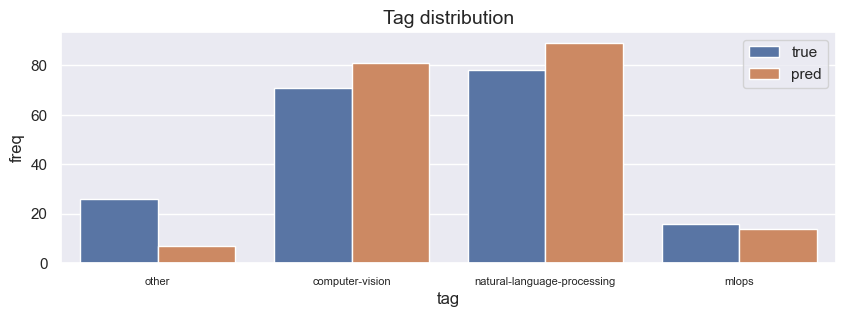

In [29]:
system_content = f"""
    You are a NLP prediction service that predicts the label given an input's title and description.
    You must choose between one of the following labels for each input: {tags}.
    Only respond with the label name and nothing else.
    """

# Zero-shot with GPT 3.5
method = "zero_shot"
model = "gpt-3.5-turbo"
y_pred[method][model], performance[method][model] = evaluate(
    test_df=test_df, model=model, system_content=system_content, tags=tags)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 191/191 [03:00<00:00,  1.06it/s]

{
  "precision": 0.9083650099213465,
  "recall": 0.9057591623036649,
  "f1": 0.9061499968017901
}


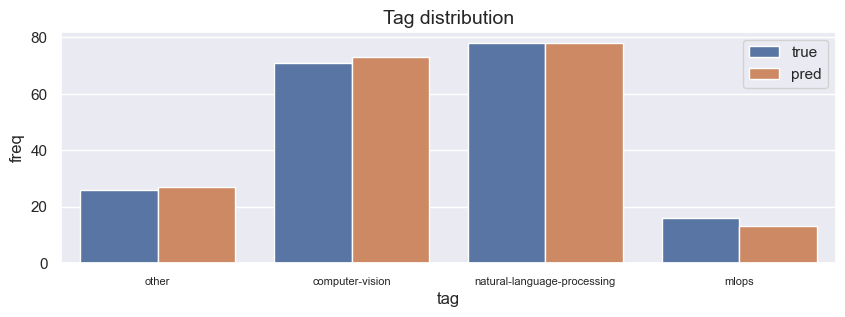

In [30]:
method = "zero_shot"
model = "gpt-4"
y_pred[method][model], performance[method][model] = evaluate(
    test_df=test_df, model=model, system_content=system_content, tags=tags)

In [33]:
# Create additional context with few samples from each class
num_samples = 2
additional_context = []
cols_to_keep = ["title", "description", "tag"]

for tag in tags:
    samples = train_df[cols_to_keep][train_df.tag == tag][:num_samples].to_dict(orient="records")
    additional_context.extend(samples)
additional_context

[{'title': 'Comparison between YOLO and RCNN on real world videos',
  'description': 'Bringing theory to experiment is cool. We can easily train models in colab and find the results in minutes.',
  'tag': 'computer-vision'},
 {'title': 'Show, Infer & Tell: Contextual Inference for Creative Captioning',
  'description': 'The beauty of the work lies in the way it architects the fundamental idea that humans look at the overall image and then individual pieces of it.\n',
  'tag': 'computer-vision'},
 {'title': 'Awesome Graph Classification',
  'description': 'A collection of important graph embedding, classification and representation learning papers with implementations.',
  'tag': 'other'},
 {'title': 'Awesome Monte Carlo Tree Search',
  'description': 'A curated list of Monte Carlo tree search papers with implementations. ',
  'tag': 'other'},
 {'title': 'Rethinking Batch Normalization in Transformers',
  'description': 'We found that NLP batch statistics exhibit large variance througho

In [34]:
# Add assistant context
assistant_content = f"""Here are some examples with the correct labels: {additional_context}"""
print (assistant_content)

Here are some examples with the correct labels: [{'title': 'Comparison between YOLO and RCNN on real world videos', 'description': 'Bringing theory to experiment is cool. We can easily train models in colab and find the results in minutes.', 'tag': 'computer-vision'}, {'title': 'Show, Infer & Tell: Contextual Inference for Creative Captioning', 'description': 'The beauty of the work lies in the way it architects the fundamental idea that humans look at the overall image and then individual pieces of it.\n', 'tag': 'computer-vision'}, {'title': 'Awesome Graph Classification', 'description': 'A collection of important graph embedding, classification and representation learning papers with implementations.', 'tag': 'other'}, {'title': 'Awesome Monte Carlo Tree Search', 'description': 'A curated list of Monte Carlo tree search papers with implementations. ', 'tag': 'other'}, {'title': 'Rethinking Batch Normalization in Transformers', 'description': 'We found that NLP batch statistics exhib

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 191/191 [02:02<00:00,  1.56it/s]

{
  "precision": 0.8509740746882725,
  "recall": 0.8743455497382199,
  "f1": 0.8532961948567581
}


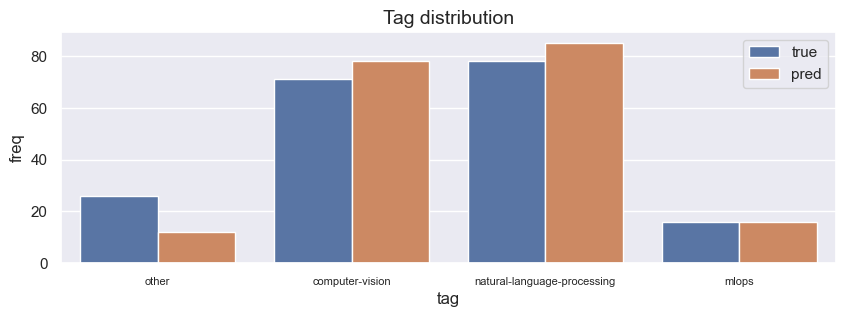

In [35]:
# Few-shot with GPT 3.5
method = "few_shot"
model = "gpt-3.5-turbo"
y_pred[method][model], performance[method][model] = evaluate(
    test_df=test_df, model=model, system_content=system_content,
    assistant_content=assistant_content, tags=tags)

## PYTORCH

In [25]:
import numpy as np
from transformers import BertTokenizer

In [26]:
# Bert tokenizer
tokenizer = BertTokenizer.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
text = "Transfer learning with transformers for text classification."
encoded_inputs = tokenizer([text], return_tensors="np", padding="longest")  # pad to longest item in batch
print ("input_ids:", encoded_inputs["input_ids"])
print ("attention_mask:", encoded_inputs["attention_mask"])
print (tokenizer.decode(encoded_inputs["input_ids"][0]))

C:\Users\PC\Desktop\MLops\PSMDSBE102\venv\lib\site-packages\huggingface_hub\file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


input_ids: [[  102  2268  1904   190 29155   168  3267  2998   205   103]]
attention_mask: [[1 1 1 1 1 1 1 1 1 1]]
[CLS] transfer learning with transformers for text classification. [SEP]


In [27]:
def tokenize(batch):
    tokenizer = BertTokenizer.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
    encoded_inputs = tokenizer(batch["text"].tolist(), return_tensors="np", padding="longest")
    return dict(ids=encoded_inputs["input_ids"], masks=encoded_inputs["attention_mask"], targets=np.array(batch["tag"]))

# Tokenization
tokenize(df.head(1))

{'ids': array([[  102,  2029,  1778,   609,  6446,  4857,  1332,  2399, 13572,
         19125,  1983,  1954,  6240,  3717,  7434,  1262,   537,   201,
          1040,   545,  4714,   103]]),
 'masks': array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]),
 'targets': array(['computer-vision'], dtype=object)}

In [28]:
def preprocess(df, class_to_index):
    """Preprocess the data."""
    df["text"] = df.title + " " + df.description  # feature engineering
    df["text"] = df.text.apply(clean_text)  # clean text
    df = df.drop(columns=["id", "created_on", "title", "description"], errors="ignore")  # clean dataframe
    df = df[["text", "tag"]]  # rearrange columns
    df["tag"] = df["tag"].map(class_to_index)  # label encoding
    outputs = tokenize(df)
    return outputs

# Apply
preprocess(df=train_df, class_to_index=class_to_index)

C:\Users\PC\Desktop\MLops\PSMDSBE102\venv\lib\site-packages\huggingface_hub\file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


{'ids': array([[  102,   856,   532, ...,     0,     0,     0],
        [  102,  2177, 29155, ...,     0,     0,     0],
        [  102,  2180,  3241, ...,     0,     0,     0],
        ...,
        [  102,   453,  2068, ...,  5730,   432,   103],
        [  102, 11268,  1782, ...,     0,     0,     0],
        [  102,  1596,   122, ...,     0,     0,     0]]),
 'masks': array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]]),
 'targets': array([0, 1, 1, 1, 1, 2, 1, 2, 3, 1, 2, 2, 1, 1, 2, 2, 2, 2, 1, 2, 0, 1,
        1, 1, 1, 1, 2, 1, 2, 0, 3, 2, 0, 1, 1, 1, 1, 2, 1, 1, 0, 2, 3, 3,
        3, 0, 2, 1, 3, 3, 1, 1, 1, 1, 2, 1, 2, 2, 2, 3, 2, 1, 1, 3, 1, 0,
        1, 2, 2, 2, 3, 2, 3, 2, 3, 2, 1, 1, 3, 3, 3, 1, 1, 2, 3, 0, 1, 1,
        1, 1, 3, 3, 0, 2, 3, 2, 2, 1, 1, 3, 2, 3, 1, 1, 1, 1, 2, 0, 0, 2,
        1, 1, 2, 2, 1, 1, 0, 3, 1

In [29]:
ray.data.DatasetContext.get_current().execution_options.preserve_order = True
ray.data.DataContext.get_current().execution_options.verbose_progress = True

In [30]:
# Data ingestion
ds = ray.data.read_csv(DATASET_LOC)
ds = ds.random_shuffle(seed=1234)
ds.take(1)

2025-04-25 18:03:07,249	INFO dataset.py:2383 -- Tip: Use `take_batch()` instead of `take() / show()` to return records in pandas or numpy batch format.
2025-04-25 18:03:07,251	INFO split_read_output_blocks.py:101 -- Using autodetected parallelism=32 for stage ReadCSV to satisfy parallelism at least twice the available number of CPUs (16).
2025-04-25 18:03:07,252	INFO split_read_output_blocks.py:106 -- To satisfy the requested parallelism of 32, each read task output is split into 32 smaller blocks.
2025-04-25 18:03:07,253	INFO streaming_executor.py:104 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV] -> AllToAllOperator[RandomShuffle] -> LimitOperator[limit=1]
2025-04-25 18:03:07,253	INFO streaming_executor.py:105 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=True)


- ReadCSV->SplitBlocks(32) 1:   0%|          | 0/32 [00:00<?, ?it/s]

- RandomShuffle 2:   0%|          | 0/32 [00:00<?, ?it/s]

Shuffle Map 3:   0%|          | 0/32 [00:00<?, ?it/s]

Shuffle Reduce 4:   0%|          | 0/32 [00:00<?, ?it/s]

- limit=1 5:   0%|          | 0/32 [00:00<?, ?it/s]

Running 0:   0%|          | 0/32 [00:00<?, ?it/s]

[{'id': 733,
  'created_on': datetime.datetime(2020, 5, 6, 4, 30, 47),
  'title': 'LandCover.ai',
  'description': 'Dataset for automatic mapping of buildings, woodlands and water from aerial imagery.',
  'tag': 'computer-vision',
  'text': 'landcover ai dataset automatic mapping buildings woodlands water aerial imagery'}]

In [31]:
import sys
sys.path.append("..")
from madewithml.data import stratify_split
from madewithml import utils
from madewithml.predict import *

In [32]:
# Split dataset
test_size = 0.2
train_ds, val_ds = stratify_split(ds, stratify="tag", test_size=test_size)

2025-04-25 18:03:11,337	INFO split_read_output_blocks.py:101 -- Using autodetected parallelism=32 for stage ReadCSV to satisfy parallelism at least twice the available number of CPUs (16).
2025-04-25 18:03:11,338	INFO split_read_output_blocks.py:106 -- To satisfy the requested parallelism of 32, each read task output is split into 32 smaller blocks.
2025-04-25 18:03:11,338	INFO streaming_executor.py:104 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV] -> AllToAllOperator[RandomShuffle] -> LimitOperator[limit=1]
2025-04-25 18:03:11,339	INFO streaming_executor.py:105 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=True)


- ReadCSV->SplitBlocks(32) 1:   0%|          | 0/32 [00:00<?, ?it/s]

- RandomShuffle 2:   0%|          | 0/32 [00:00<?, ?it/s]

Shuffle Map 3:   0%|          | 0/32 [00:00<?, ?it/s]

Shuffle Reduce 4:   0%|          | 0/32 [00:00<?, ?it/s]

- limit=1 5:   0%|          | 0/32 [00:00<?, ?it/s]

Running 0:   0%|          | 0/32 [00:00<?, ?it/s]

In [33]:
# Mapping
tags = train_ds.unique(column="tag")
class_to_index = {tag: i for i, tag in enumerate(tags)}

# Distributed preprocessing
sample_ds = train_ds.map_batches(
  preprocess,
  fn_kwargs={"class_to_index": class_to_index},
  batch_format="pandas")
sample_ds.show(1)

2025-04-25 18:03:14,199	INFO split_read_output_blocks.py:101 -- Using autodetected parallelism=32 for stage ReadCSV to satisfy parallelism at least twice the available number of CPUs (16).
2025-04-25 18:03:14,199	INFO split_read_output_blocks.py:106 -- To satisfy the requested parallelism of 32, each read task output is split into 32 smaller blocks.
2025-04-25 18:03:14,199	INFO streaming_executor.py:104 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(<lambda>)] -> LimitOperator[limit=1]
2025-04-25 18:03:14,199	INFO streaming_executor.py:105 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=True)


- ReadCSV->SplitBlocks(32) 1:   0%|          | 0/32 [00:00<?, ?it/s]

- RandomShuffle 2:   0%|          | 0/32 [00:00<?, ?it/s]

Shuffle Map 3:   0%|          | 0/32 [00:00<?, ?it/s]

Shuffle Reduce 4:   0%|          | 0/32 [00:00<?, ?it/s]

- Sort 5:   0%|          | 0/32 [00:00<?, ?it/s]

Sort Sample 6:   0%|          | 0/32 [00:00<?, ?it/s]

Shuffle Map 7:   0%|          | 0/32 [00:00<?, ?it/s]

Shuffle Reduce 8:   0%|          | 0/32 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 9:   0%|          | 0/32 [00:00<?, ?it/s]

Shuffle Map 10:   0%|          | 0/32 [00:00<?, ?it/s]

Shuffle Reduce 11:   0%|          | 0/32 [00:00<?, ?it/s]

- MapBatches(<lambda>) 12:   0%|          | 0/32 [00:00<?, ?it/s]

- limit=1 13:   0%|          | 0/32 [00:00<?, ?it/s]

Running 0:   0%|          | 0/32 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/32 [00:00<?, ?it/s]

2025-04-25 18:03:17,975	INFO split_read_output_blocks.py:101 -- Using autodetected parallelism=32 for stage ReadCSV to satisfy parallelism at least twice the available number of CPUs (16).
2025-04-25 18:03:17,976	INFO split_read_output_blocks.py:106 -- To satisfy the requested parallelism of 32, each read task output is split into 32 smaller blocks.
2025-04-25 18:03:17,976	INFO streaming_executor.py:104 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(<lambda>)] -> AllToAllOperator[Aggregate]
2025-04-25 18:03:17,978	INFO streaming_executor.py:105 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=True)


- ReadCSV->SplitBlocks(32) 1:   0%|          | 0/32 [00:00<?, ?it/s]

- RandomShuffle 2:   0%|          | 0/32 [00:00<?, ?it/s]

Shuffle Map 3:   0%|          | 0/32 [00:00<?, ?it/s]

Shuffle Reduce 4:   0%|          | 0/32 [00:00<?, ?it/s]

- Sort 5:   0%|          | 0/32 [00:00<?, ?it/s]

Sort Sample 6:   0%|          | 0/32 [00:00<?, ?it/s]

Shuffle Map 7:   0%|          | 0/32 [00:00<?, ?it/s]

Shuffle Reduce 8:   0%|          | 0/32 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 9:   0%|          | 0/32 [00:00<?, ?it/s]

Shuffle Map 10:   0%|          | 0/32 [00:00<?, ?it/s]

Shuffle Reduce 11:   0%|          | 0/32 [00:00<?, ?it/s]

- MapBatches(<lambda>) 12:   0%|          | 0/32 [00:00<?, ?it/s]

- Aggregate 13:   0%|          | 0/32 [00:00<?, ?it/s]

Shuffle Map 14:   0%|          | 0/32 [00:00<?, ?it/s]

Shuffle Reduce 15:   0%|          | 0/32 [00:00<?, ?it/s]

Running 0:   0%|          | 0/32 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/32 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/32 [00:00<?, ?it/s]

2025-04-25 18:03:21,396	INFO split_read_output_blocks.py:101 -- Using autodetected parallelism=32 for stage ReadCSV to satisfy parallelism at least twice the available number of CPUs (16).
2025-04-25 18:03:21,397	INFO split_read_output_blocks.py:106 -- To satisfy the requested parallelism of 32, each read task output is split into 32 smaller blocks.
2025-04-25 18:03:21,397	INFO streaming_executor.py:104 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(preprocess)] -> LimitOperator[limit=1]
2025-04-25 18:03:21,398	INFO streaming_executor.py:105 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=True)


- ReadCSV->SplitBlocks(32) 1:   0%|          | 0/32 [00:00<?, ?it/s]

- RandomShuffle 2:   0%|          | 0/32 [00:00<?, ?it/s]

Shuffle Map 3:   0%|          | 0/32 [00:00<?, ?it/s]

Shuffle Reduce 4:   0%|          | 0/32 [00:00<?, ?it/s]

- Sort 5:   0%|          | 0/32 [00:00<?, ?it/s]

Sort Sample 6:   0%|          | 0/32 [00:00<?, ?it/s]

Shuffle Map 7:   0%|          | 0/32 [00:00<?, ?it/s]

Shuffle Reduce 8:   0%|          | 0/32 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 9:   0%|          | 0/32 [00:00<?, ?it/s]

Shuffle Map 10:   0%|          | 0/32 [00:00<?, ?it/s]

Shuffle Reduce 11:   0%|          | 0/32 [00:00<?, ?it/s]

- MapBatches(preprocess) 12:   0%|          | 0/32 [00:00<?, ?it/s]

- limit=1 13:   0%|          | 0/32 [00:00<?, ?it/s]

Running 0:   0%|          | 0/32 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/32 [00:00<?, ?it/s]

{'ids': array([  102,  3450,  1183, 30111,  3997,  1904, 23576, 10385,   532,
        2568,   453,   103,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0]), 'masks': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0]), 'targets': 3}


In [34]:
DATASET_LOC = "dataset.csv"

In [35]:
import os
import random
import torch
from ray.data.preprocessor import Preprocessor
from ray.train.torch import get_device

In [36]:
def set_seeds(seed=42):
    """Set seeds for reproducibility."""
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    eval("setattr(torch.backends.cudnn, 'deterministic', True)")
    eval("setattr(torch.backends.cudnn, 'benchmark', False)")
    os.environ["PYTHONHASHSEED"] = str(seed)

In [37]:
def load_data(num_samples=None):
    ds = ray.data.read_csv(DATASET_LOC)
    ds = ds.random_shuffle(seed=1234)
    ds = ray.data.from_items(ds.take(num_samples)) if num_samples else ds
    return ds

In [38]:
class CustomPreprocessor(Preprocessor):
    """Custom preprocessor class."""
    def _fit(self, ds):
        tags = ds.unique(column="tag")
        self.class_to_index = {tag: i for i, tag in enumerate(tags)}
        self.index_to_class = {v:k for k, v in self.class_to_index.items()}
    def _transform_pandas(self, batch):  # could also do _transform_numpy
        return preprocess(batch, class_to_index=self.class_to_index)

In [39]:
import torch.nn as nn
from transformers import BertModel

In [40]:
# Pretrained LLM
llm = BertModel.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
embedding_dim = llm.config.hidden_size

C:\Users\PC\Desktop\MLops\PSMDSBE102\venv\lib\site-packages\huggingface_hub\file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you 

In [41]:
# Sample
text = "Transfer learning with transformers for text classification."
batch = tokenizer([text], return_tensors="np", padding="longest")
batch = {k:torch.tensor(v) for k,v in batch.items()}  # convert to torch tensors
seq, pool = llm(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"])
np.shape(seq), np.shape(pool)

(torch.Size([1, 10, 768]), torch.Size([1, 768]))

In [42]:
class FinetunedLLM(nn.Module):
    def __init__(self, llm, dropout_p, embedding_dim, num_classes):
        super(FinetunedLLM, self).__init__()
        self.llm = llm
        self.dropout = torch.nn.Dropout(dropout_p)
        self.fc1 = torch.nn.Linear(embedding_dim, num_classes)
        
    def forward(self, batch):
        ids, masks = batch["ids"], batch["masks"]
        seq, pool = self.llm(input_ids=ids, attention_mask=masks)
        z = self.dropout(pool)
        z = self.fc1(z)
        return z
    
    @torch.inference_mode()
    def predict(self, batch):
        self.eval()
        z = self(inputs)
        y_pred = torch.argmax(z, dim=1).cpu().numpy()
        return y_pred
    
    @torch.inference_mode()
    def predict_proba(self, batch):
        self.eval()
        z = self(batch)
        y_probs = F.softmax(z).cpu().numpy()
        return y_probs

In [43]:
# Initialize model
model = FinetunedLLM(llm=llm, dropout_p=0.5, embedding_dim=embedding_dim, num_classes=num_classes)
print (model.named_parameters)

<bound method Module.named_parameters of FinetunedLLM(
  (llm): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31090, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): Layer

In [44]:
from ray.train import Checkpoint, session
from ray import train
from ray.air.config import CheckpointConfig, DatasetConfig, RunConfig, ScalingConfig
import ray.train as train
from ray.train.torch import TorchCheckpoint, TorchTrainer
import torch.nn.functional as F

In [45]:
def pad_array(arr: np.ndarray, dtype=np.int32) -> np.ndarray:
    max_len = max(len(row) for row in arr)
    padded_arr = np.zeros((arr.shape[0], max_len), dtype=dtype)
    for i, row in enumerate(arr):
        padded_arr[i][: len(row)] = row
    return padded_arr

In [46]:
def collate_fn(batch):
    batch["ids"] = pad_array(batch["ids"])
    batch["masks"] = pad_array(batch["masks"])
    dtypes = {"ids": torch.int32, "masks": torch.int32, "targets": torch.int64}
    tensor_batch = {}
    for key, array in batch.items():
        tensor_batch[key] = torch.as_tensor(array, dtype=dtypes[key], device=get_device())
    return tensor_batch

In [47]:
def train_step(ds, batch_size, model, num_classes, loss_fn, optimizer):
    """Train step."""
    model.train()
    loss = 0.0

    ds_generator = ds.iter_torch_batches(batch_size=batch_size, collate_fn=collate_fn)

    for i, batch in enumerate(ds_generator):
        optimizer.zero_grad()  # reset gradients
        z = model(batch)  # forward pass
        targets = F.one_hot(batch["targets"], num_classes=num_classes).float()  # one-hot (for loss_fn)
        J = loss_fn(z, targets)  # define loss
        J.backward()  # backward pass
        optimizer.step()  # update weights
        loss += (J.detach().item() - loss) / (i + 1)  # cumulative loss
    return loss

In [48]:
def eval_step(ds, batch_size, model, num_classes, loss_fn):
    """Eval step."""
    model.eval()
    loss = 0.0
    y_trues, y_preds = [], []
    ds_generator = ds.iter_torch_batches(batch_size=batch_size, collate_fn=utils.collate_fn)
    with torch.inference_mode():
        for i, batch in enumerate(ds_generator):
            z = model(batch)
            targets = F.one_hot(batch["targets"], num_classes=num_classes).float()  # one-hot (for loss_fn)
            J = loss_fn(z, targets).item()
            loss += (J - loss) / (i + 1)
            y_trues.extend(batch["targets"].cpu().numpy())
            y_preds.extend(torch.argmax(z, dim=1).cpu().numpy())
    return loss, np.vstack(y_trues), np.vstack(y_preds)

In [49]:
# Training loop
def train_loop_per_worker(config):
    # Hyperparameters
    dropout_p = config["dropout_p"]
    lr = config["lr"]
    lr_factor = config["lr_factor"]
    lr_patience = config["lr_patience"]
    num_epochs = config["num_epochs"]
    batch_size = config["batch_size"]
    num_classes = config["num_classes"]

    # Get datasets
    set_seeds()
    train_ds = ray.train.get_dataset_shard("train")
    val_ds = ray.train.get_dataset_shard("val")

    # Model
    llm = BertModel.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
    model = FinetunedLLM(llm=llm, dropout_p=dropout_p, embedding_dim=llm.config.hidden_size, num_classes=num_classes)
    model = train.torch.prepare_model(model)

    # Training components
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=lr_factor, patience=lr_patience)

    # Training
    batch_size_per_worker = batch_size // train.get_context().get_world_size()
    for epoch in range(num_epochs):
        # Step
        train_loss = train_step(train_ds, batch_size_per_worker, model, num_classes, loss_fn, optimizer)
        val_loss, _, _ = eval_step(val_ds, batch_size_per_worker, model, num_classes, loss_fn)
        scheduler.step(val_loss)

        # Checkpoint
        metrics = dict(epoch=epoch, lr=optimizer.param_groups[0]["lr"], train_loss=train_loss, val_loss=val_loss)
        #checkpoint = TorchCheckpoint.from_model(model=model)
        checkpoint = TorchCheckpoint.from_state_dict(model.state_dict())
        train.report(metrics, checkpoint=checkpoint)

In [50]:
# Train loop config
train_loop_config = {
    "dropout_p": 0.5,
    "lr": 1e-4,
    "lr_factor": 0.8,
    "lr_patience": 3,
    "num_epochs": 10,
    "batch_size": 256,
    "num_classes": num_classes,
}

In [51]:
# Scaling config
scaling_config = ScalingConfig(
    num_workers=2,
    use_gpu=False,
    #resources_per_worker={"CPU":1},
)

In [52]:
from datetime import datetime
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Run config
checkpoint_config = CheckpointConfig(num_to_keep=1, checkpoint_score_attribute="val_loss", checkpoint_score_order="min")
#run_config = RunConfig(name="llm", checkpoint_config=checkpoint_config, local_dir="~/ray_results")
run_config = RunConfig(
    name="HOA",
    checkpoint_config=checkpoint_config,
    local_dir=f"C:/Users/PC/ray_results_12/ray_{timestamp}",
)

In [53]:
ds = load_data()
train_ds, val_ds = ds.train_test_split(test_size = test_size)

2025-04-25 18:04:03,615	INFO split_read_output_blocks.py:101 -- Using autodetected parallelism=32 for stage ReadCSV to satisfy parallelism at least twice the available number of CPUs (16).
2025-04-25 18:04:03,616	INFO split_read_output_blocks.py:106 -- To satisfy the requested parallelism of 32, each read task output is split into 32 smaller blocks.
2025-04-25 18:04:03,616	INFO streaming_executor.py:104 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV] -> AllToAllOperator[RandomShuffle]
2025-04-25 18:04:03,617	INFO streaming_executor.py:105 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=True)


- ReadCSV->SplitBlocks(32) 1:   0%|          | 0/32 [00:00<?, ?it/s]

- RandomShuffle 2:   0%|          | 0/32 [00:00<?, ?it/s]

Shuffle Map 3:   0%|          | 0/32 [00:00<?, ?it/s]

Shuffle Reduce 4:   0%|          | 0/32 [00:00<?, ?it/s]

Running 0:   0%|          | 0/32 [00:00<?, ?it/s]

In [54]:
# Preprocess
preprocessor = CustomPreprocessor()
train_ds =  preprocessor.fit_transform(train_ds)
val_ds = preprocessor.transform(val_ds)
train_ds = train_ds.materialize()
val_ds = val_ds.materialize()

2025-04-25 18:04:04,020	INFO streaming_executor.py:104 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[MapBatches(<lambda>)] -> LimitOperator[limit=1]
2025-04-25 18:04:04,020	INFO streaming_executor.py:105 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=True)


- MapBatches(<lambda>) 1:   0%|          | 0/26 [00:00<?, ?it/s]

- limit=1 2:   0%|          | 0/26 [00:00<?, ?it/s]

Running 0:   0%|          | 0/26 [00:00<?, ?it/s]

2025-04-25 18:04:04,108	INFO streaming_executor.py:104 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[MapBatches(<lambda>)] -> AllToAllOperator[Aggregate]
2025-04-25 18:04:04,109	INFO streaming_executor.py:105 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=True)


- MapBatches(<lambda>) 1:   0%|          | 0/26 [00:00<?, ?it/s]

- Aggregate 2:   0%|          | 0/26 [00:00<?, ?it/s]

Shuffle Map 3:   0%|          | 0/26 [00:00<?, ?it/s]

Shuffle Reduce 4:   0%|          | 0/26 [00:00<?, ?it/s]

Running 0:   0%|          | 0/26 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/26 [00:00<?, ?it/s]

2025-04-25 18:04:04,295	INFO streaming_executor.py:104 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[MapBatches(CustomPreprocessor._transform_pandas)]
2025-04-25 18:04:04,297	INFO streaming_executor.py:105 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=True)


- MapBatches(CustomPreprocessor._transform_pandas) 1:   0%|          | 0/26 [00:00<?, ?it/s]

Running 0:   0%|          | 0/26 [00:00<?, ?it/s]

2025-04-25 18:04:05,594	INFO streaming_executor.py:104 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[MapBatches(CustomPreprocessor._transform_pandas)]
2025-04-25 18:04:05,595	INFO streaming_executor.py:105 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=True)


- MapBatches(CustomPreprocessor._transform_pandas) 1:   0%|          | 0/7 [00:00<?, ?it/s]

Running 0:   0%|          | 0/7 [00:00<?, ?it/s]

In [55]:
# Trainer
trainer = TorchTrainer(
    train_loop_per_worker=train_loop_per_worker,
    train_loop_config=train_loop_config,
    scaling_config=scaling_config,
    run_config=run_config,
    datasets={"train": train_ds, "val": val_ds},
)

In [77]:
#Train
results = trainer.fit()

2025-04-25 00:24:33,710	INFO data_parallel_trainer.py:338 -- GPUs are detected in your Ray cluster, but GPU training is not enabled for this trainer. To enable GPU training, make sure to set `use_gpu` to True in your scaling config.


(pid=24116) - split(2, equal=True) 1:   0%|          | 0/26 [00:00<?, ?it/s]

(pid=24116) Running 0:   0%|          | 0/26 [00:00<?, ?it/s]

(pid=5264) - split(2, equal=True) 1:   0%|          | 0/7 [00:00<?, ?it/s]

(pid=5264) Running 0:   0%|          | 0/7 [00:00<?, ?it/s]

(pid=24116) - split(2, equal=True) 1:   0%|          | 0/26 [00:00<?, ?it/s]

(pid=24116) Running 0:   0%|          | 0/26 [00:00<?, ?it/s]

(pid=5264) - split(2, equal=True) 1:   0%|          | 0/7 [00:00<?, ?it/s]

(pid=5264) Running 0:   0%|          | 0/7 [00:00<?, ?it/s]

(pid=24116) - split(2, equal=True) 1:   0%|          | 0/26 [00:00<?, ?it/s]

(pid=24116) Running 0:   0%|          | 0/26 [00:00<?, ?it/s]

(pid=5264) - split(2, equal=True) 1:   0%|          | 0/7 [00:00<?, ?it/s]

(pid=5264) Running 0:   0%|          | 0/7 [00:00<?, ?it/s]

(pid=24116) - split(2, equal=True) 1:   0%|          | 0/26 [00:00<?, ?it/s]

(pid=24116) Running 0:   0%|          | 0/26 [00:00<?, ?it/s]

(pid=5264) - split(2, equal=True) 1:   0%|          | 0/7 [00:00<?, ?it/s]

(pid=5264) Running 0:   0%|          | 0/7 [00:00<?, ?it/s]

(pid=24116) - split(2, equal=True) 1:   0%|          | 0/26 [00:00<?, ?it/s]

(pid=24116) Running 0:   0%|          | 0/26 [00:00<?, ?it/s]

(pid=5264) - split(2, equal=True) 1:   0%|          | 0/7 [00:00<?, ?it/s]

(pid=5264) Running 0:   0%|          | 0/7 [00:00<?, ?it/s]

(pid=24116) - split(2, equal=True) 1:   0%|          | 0/26 [00:00<?, ?it/s]

(pid=24116) Running 0:   0%|          | 0/26 [00:00<?, ?it/s]

(pid=5264) - split(2, equal=True) 1:   0%|          | 0/7 [00:00<?, ?it/s]

(pid=5264) Running 0:   0%|          | 0/7 [00:00<?, ?it/s]

(pid=24116) - split(2, equal=True) 1:   0%|          | 0/26 [00:00<?, ?it/s]

(pid=24116) Running 0:   0%|          | 0/26 [00:00<?, ?it/s]

(pid=5264) - split(2, equal=True) 1:   0%|          | 0/7 [00:00<?, ?it/s]

(pid=5264) Running 0:   0%|          | 0/7 [00:00<?, ?it/s]

(pid=24116) - split(2, equal=True) 1:   0%|          | 0/26 [00:00<?, ?it/s]

(pid=24116) Running 0:   0%|          | 0/26 [00:00<?, ?it/s]

(pid=5264) - split(2, equal=True) 1:   0%|          | 0/7 [00:00<?, ?it/s]

(pid=5264) Running 0:   0%|          | 0/7 [00:00<?, ?it/s]

(pid=24116) - split(2, equal=True) 1:   0%|          | 0/26 [00:00<?, ?it/s]

(pid=24116) Running 0:   0%|          | 0/26 [00:00<?, ?it/s]

(pid=5264) - split(2, equal=True) 1:   0%|          | 0/7 [00:00<?, ?it/s]

(pid=5264) Running 0:   0%|          | 0/7 [00:00<?, ?it/s]

(pid=24116) - split(2, equal=True) 1:   0%|          | 0/26 [00:00<?, ?it/s]

(pid=24116) Running 0:   0%|          | 0/26 [00:00<?, ?it/s]

(pid=5264) - split(2, equal=True) 1:   0%|          | 0/7 [00:00<?, ?it/s]

(pid=5264) Running 0:   0%|          | 0/7 [00:00<?, ?it/s]

2025-04-25 00:51:02,770	INFO tune.py:1047 -- Total run time: 1589.07 seconds (1589.05 seconds for the tuning loop).


In [ ]:
#trainer = TorchTrainer.restore(f"C:/Users/PC/ray_results_12/ray_)

In [78]:
df_metrics = results.metrics_dataframe
df_metrics

,epoch,lr,train_loss,val_loss,timestamp,checkpoint_dir_name,should_checkpoint,done,training_iteration,trial_id,...,node_ip,time_since_restore,iterations_since_restore,config/train_loop_config/dropout_p,config/train_loop_config/lr,config/train_loop_config/lr_factor,config/train_loop_config/lr_patience,config/train_loop_config/num_epochs,config/train_loop_config/batch_size,config/train_loop_config/num_classes
0,0,0.0001,0.590041,0.493575,1745512042,checkpoint_000000,True,False,1,9b568_00000,...,127.0.0.1,162.848801,1,0.5,0.0001,0.8,3,10,256,4
1,1,0.0001,0.500522,0.421995,1745512198,checkpoint_000001,True,False,2,9b568_00000,...,127.0.0.1,319.283572,2,0.5,0.0001,0.8,3,10,256,4
2,2,0.0001,0.385575,0.287219,1745512356,checkpoint_000002,True,False,3,9b568_00000,...,127.0.0.1,477.588292,3,0.5,0.0001,0.8,3,10,256,4
3,3,0.0001,0.281391,0.229626,1745512514,checkpoint_000003,True,False,4,9b568_00000,...,127.0.0.1,635.596355,4,0.5,0.0001,0.8,3,10,256,4
4,4,0.0001,0.212191,0.193380,1745512672,checkpoint_000004,True,False,5,9b568_00000,...,127.0.0.1,793.689693,5,0.5,0.0001,0.8,3,10,256,4
5,5,0.0001,0.152783,0.210341,1745512830,checkpoint_000005,True,False,6,9b568_00000,...,127.0.0.1,951.456884,6,0.5,0.0001,0.8,3,10,256,4
6,6,0.0001,0.110729,0.180595,1745512987,checkpoint_000006,True,False,7,9b568_00000,...,127.0.0.1,1108.755774,7,0.5,0.0001,0.8,3,10,256,4
7,7,0.0001,0.080966,0.178507,1745513145,checkpoint_000007,True,False,8,9b568_00000,...,127.0.0.1,1266.833425,8,0.5,0.0001,0.8,3,10,256,4
8,8,0.0001,0.053478,0.194332,1745513303,checkpoint_000008,True,False,9,9b568_00000,...,127.0.0.1,1424.447553,9,0.5,0.0001,0.8,3,10,256,4
9,9,0.0001,0.045589,0.186373,1745513460,checkpoint_000009,True,False,10,9b568_00000,...,127.0.0.1,1581.624216,10,0.5,0.0001,0.8,3,10,256,4


In [79]:
results.best_checkpoints

[(Checkpoint(filesystem=local, path=C:/Users/PC/ray_results_12/ray_20250425_002427/HOA/TorchTrainer_9b568_00000_0_2025-04-25_00-24-33/checkpoint_000007),
  {'epoch': 7,
   'lr': 0.0001,
   'train_loss': 0.08096614355842273,
   'val_loss': 0.17850707471370697,
   'timestamp': 1745513145,
   'checkpoint_dir_name': 'checkpoint_000007',
   'should_checkpoint': True,
   'done': False,
   'training_iteration': 8,
   'trial_id': '9b568_00000',
   'date': '2025-04-25_00-45-46',
   'time_this_iter_s': 158.0776505470276,
   'time_total_s': 1266.8334250450134,
   'pid': 26300,
   'hostname': 'Johnny',
   'node_ip': '127.0.0.1',
   'config': {'train_loop_config': {'dropout_p': 0.5,
     'lr': 0.0001,
     'lr_factor': 0.8,
     'lr_patience': 3,
     'num_epochs': 10,
     'batch_size': 256,
     'num_classes': 4}},
   'time_since_restore': 1266.8334250450134,
   'iterations_since_restore': 8})]

# HOA 2.2 - Experiment Tracking

In [56]:
import mlflow
from pathlib import Path
import time
from ray.air.integrations.mlflow import MLflowLoggerCallback
from ray.air.config import RunConfig, CheckpointConfig

In [57]:
# Config MLflow
MODEL_REGISTRY = Path("/tmp/mlflow10")
Path(MODEL_REGISTRY).mkdir(parents=True, exist_ok=True)
MLFLOW_TRACKING_URI = "file:///" + str(MODEL_REGISTRY.absolute())
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
print (mlflow.get_tracking_uri())

file:///C:\tmp\mlflow10


In [58]:
# MLflow callback
experiment_name = f"HOA_Mlflow-{int(time.time())}"
mlflow_callback = MLflowLoggerCallback(
    tracking_uri=MLFLOW_TRACKING_URI,
    experiment_name=experiment_name,
    save_artifact=True)

In [59]:
# Run configuration with MLflow callback
run_config = RunConfig(
    callbacks=[mlflow_callback],
    checkpoint_config=checkpoint_config,
    local_dir=f"C:/Users/PC/mlflow_experiment"
)

In [60]:
# Dataset
ds = load_data()
train_ds, val_ds = ds.train_test_split(test_size=test_size)

2025-04-25 18:04:35,640	INFO split_read_output_blocks.py:101 -- Using autodetected parallelism=32 for stage ReadCSV to satisfy parallelism at least twice the available number of CPUs (16).
2025-04-25 18:04:35,641	INFO split_read_output_blocks.py:106 -- To satisfy the requested parallelism of 32, each read task output is split into 32 smaller blocks.
2025-04-25 18:04:35,641	INFO streaming_executor.py:104 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV] -> AllToAllOperator[RandomShuffle]
2025-04-25 18:04:35,642	INFO streaming_executor.py:105 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=True)


- ReadCSV->SplitBlocks(32) 1:   0%|          | 0/32 [00:00<?, ?it/s]

- RandomShuffle 2:   0%|          | 0/32 [00:00<?, ?it/s]

Shuffle Map 3:   0%|          | 0/32 [00:00<?, ?it/s]

Shuffle Reduce 4:   0%|          | 0/32 [00:00<?, ?it/s]

Running 0:   0%|          | 0/32 [00:00<?, ?it/s]

2025-04-25 18:04:35,806	WARNING plan.py:577 -- Warning: The Ray cluster currently does not have any available CPUs. The Dataset job will hang unless more CPUs are freed up. A common reason is that cluster resources are used by Actors or Tune trials; see the following link for more details: https://docs.ray.io/en/latest/data/data-internals.html#ray-data-and-tune


In [61]:
# Preprocess
preprocessor = CustomPreprocessor()
train_ds = preprocessor.fit_transform(train_ds)
val_ds = preprocessor.transform(val_ds)
train_ds = train_ds.materialize()
val_ds = val_ds.materialize()

2025-04-25 18:04:36,974	INFO streaming_executor.py:104 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[MapBatches(<lambda>)] -> LimitOperator[limit=1]
2025-04-25 18:04:36,974	INFO streaming_executor.py:105 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=True)


- MapBatches(<lambda>) 1:   0%|          | 0/26 [00:00<?, ?it/s]

- limit=1 2:   0%|          | 0/26 [00:00<?, ?it/s]

Running 0:   0%|          | 0/26 [00:00<?, ?it/s]

2025-04-25 18:04:37,051	INFO streaming_executor.py:104 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[MapBatches(<lambda>)] -> AllToAllOperator[Aggregate]
2025-04-25 18:04:37,052	INFO streaming_executor.py:105 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=True)


- MapBatches(<lambda>) 1:   0%|          | 0/26 [00:00<?, ?it/s]

- Aggregate 2:   0%|          | 0/26 [00:00<?, ?it/s]

Shuffle Map 3:   0%|          | 0/26 [00:00<?, ?it/s]

Shuffle Reduce 4:   0%|          | 0/26 [00:00<?, ?it/s]

Running 0:   0%|          | 0/26 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/26 [00:00<?, ?it/s]

2025-04-25 18:04:37,226	INFO streaming_executor.py:104 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[MapBatches(CustomPreprocessor._transform_pandas)]
2025-04-25 18:04:37,228	INFO streaming_executor.py:105 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=True)


- MapBatches(CustomPreprocessor._transform_pandas) 1:   0%|          | 0/26 [00:00<?, ?it/s]

Running 0:   0%|          | 0/26 [00:00<?, ?it/s]

2025-04-25 18:04:38,563	INFO streaming_executor.py:104 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[MapBatches(CustomPreprocessor._transform_pandas)]
2025-04-25 18:04:38,564	INFO streaming_executor.py:105 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=True)


- MapBatches(CustomPreprocessor._transform_pandas) 1:   0%|          | 0/7 [00:00<?, ?it/s]

Running 0:   0%|          | 0/7 [00:00<?, ?it/s]

In [62]:
# Trainer
trainer = TorchTrainer(
    train_loop_per_worker=train_loop_per_worker,
    train_loop_config=train_loop_config,
    scaling_config=scaling_config,
    run_config=run_config,  # uses RunConfig with MLflow callback
    datasets={"train": train_ds, "val": val_ds},
)

In [71]:
# Train
results = trainer.fit()

2025-04-25 08:05:21,712	INFO data_parallel_trainer.py:338 -- GPUs are detected in your Ray cluster, but GPU training is not enabled for this trainer. To enable GPU training, make sure to set `use_gpu` to True in your scaling config.


(pid=20156) - split(2, equal=True) 1:   0%|          | 0/26 [00:00<?, ?it/s]

(pid=20156) Running 0:   0%|          | 0/26 [00:00<?, ?it/s]

(pid=640) - split(2, equal=True) 1:   0%|          | 0/7 [00:00<?, ?it/s]

(pid=640) Running 0:   0%|          | 0/7 [00:00<?, ?it/s]

(pid=20156) - split(2, equal=True) 1:   0%|          | 0/26 [00:00<?, ?it/s]

(pid=20156) Running 0:   0%|          | 0/26 [00:00<?, ?it/s]

(pid=640) - split(2, equal=True) 1:   0%|          | 0/7 [00:00<?, ?it/s]

(pid=640) Running 0:   0%|          | 0/7 [00:00<?, ?it/s]

(pid=20156) - split(2, equal=True) 1:   0%|          | 0/26 [00:00<?, ?it/s]

(pid=20156) Running 0:   0%|          | 0/26 [00:00<?, ?it/s]

(pid=640) - split(2, equal=True) 1:   0%|          | 0/7 [00:00<?, ?it/s]

(pid=640) Running 0:   0%|          | 0/7 [00:00<?, ?it/s]

(pid=20156) - split(2, equal=True) 1:   0%|          | 0/26 [00:00<?, ?it/s]

(pid=20156) Running 0:   0%|          | 0/26 [00:00<?, ?it/s]

(pid=640) - split(2, equal=True) 1:   0%|          | 0/7 [00:00<?, ?it/s]

(pid=640) Running 0:   0%|          | 0/7 [00:00<?, ?it/s]

(pid=20156) - split(2, equal=True) 1:   0%|          | 0/26 [00:00<?, ?it/s]

(pid=20156) Running 0:   0%|          | 0/26 [00:00<?, ?it/s]

(pid=640) - split(2, equal=True) 1:   0%|          | 0/7 [00:00<?, ?it/s]

(pid=640) Running 0:   0%|          | 0/7 [00:00<?, ?it/s]

(pid=20156) - split(2, equal=True) 1:   0%|          | 0/26 [00:00<?, ?it/s]

(pid=20156) Running 0:   0%|          | 0/26 [00:00<?, ?it/s]

(pid=640) - split(2, equal=True) 1:   0%|          | 0/7 [00:00<?, ?it/s]

(pid=640) Running 0:   0%|          | 0/7 [00:00<?, ?it/s]

(pid=20156) - split(2, equal=True) 1:   0%|          | 0/26 [00:00<?, ?it/s]

(pid=20156) Running 0:   0%|          | 0/26 [00:00<?, ?it/s]

(pid=640) - split(2, equal=True) 1:   0%|          | 0/7 [00:00<?, ?it/s]

(pid=640) Running 0:   0%|          | 0/7 [00:00<?, ?it/s]

(pid=20156) - split(2, equal=True) 1:   0%|          | 0/26 [00:00<?, ?it/s]

(pid=20156) Running 0:   0%|          | 0/26 [00:00<?, ?it/s]

(pid=640) - split(2, equal=True) 1:   0%|          | 0/7 [00:00<?, ?it/s]

(pid=640) Running 0:   0%|          | 0/7 [00:00<?, ?it/s]

(pid=20156) - split(2, equal=True) 1:   0%|          | 0/26 [00:00<?, ?it/s]

(pid=20156) Running 0:   0%|          | 0/26 [00:00<?, ?it/s]

(pid=640) - split(2, equal=True) 1:   0%|          | 0/7 [00:00<?, ?it/s]

(pid=640) Running 0:   0%|          | 0/7 [00:00<?, ?it/s]

(pid=20156) - split(2, equal=True) 1:   0%|          | 0/26 [00:00<?, ?it/s]

(pid=20156) Running 0:   0%|          | 0/26 [00:00<?, ?it/s]

(pid=640) - split(2, equal=True) 1:   0%|          | 0/7 [00:00<?, ?it/s]

(pid=640) Running 0:   0%|          | 0/7 [00:00<?, ?it/s]

2025-04-25 08:45:40,746	INFO tune.py:1047 -- Total run time: 2419.05 seconds (2419.01 seconds for the tuning loop).


In [72]:
#result_path = "C:/Users/PC/ray_mlflow5/experiment/20250425_002427/TorchTrainer_2025-04-25_01-54-33/TorchTrainer_2dc7e_00000_0_2025-04-25_01-54-33"


In [73]:
#from ray.air import Result
#result = Result.from_path(result_path)

In [74]:
results.metrics_dataframe

,epoch,lr,train_loss,val_loss,timestamp,checkpoint_dir_name,should_checkpoint,done,training_iteration,trial_id,...,node_ip,time_since_restore,iterations_since_restore,config/train_loop_config/dropout_p,config/train_loop_config/lr,config/train_loop_config/lr_factor,config/train_loop_config/lr_patience,config/train_loop_config/num_epochs,config/train_loop_config/batch_size,config/train_loop_config/num_classes
0,0,0.0001,0.590041,0.493575,1745539770,checkpoint_000000,True,False,1,fad48_00000,...,127.0.0.1,245.397272,1,0.5,0.0001,0.8,3,10,256,4
1,1,0.0001,0.500522,0.421995,1745540011,checkpoint_000001,True,False,2,fad48_00000,...,127.0.0.1,485.678218,2,0.5,0.0001,0.8,3,10,256,4
2,2,0.0001,0.385575,0.287219,1745540256,checkpoint_000002,True,False,3,fad48_00000,...,127.0.0.1,730.153498,3,0.5,0.0001,0.8,3,10,256,4
3,3,0.0001,0.281391,0.229626,1745540499,checkpoint_000003,True,False,4,fad48_00000,...,127.0.0.1,973.912505,4,0.5,0.0001,0.8,3,10,256,4
4,4,0.0001,0.212191,0.193380,1745540739,checkpoint_000004,True,False,5,fad48_00000,...,127.0.0.1,1212.890335,5,0.5,0.0001,0.8,3,10,256,4
5,5,0.0001,0.152783,0.210341,1745540982,checkpoint_000005,True,False,6,fad48_00000,...,127.0.0.1,1456.416104,6,0.5,0.0001,0.8,3,10,256,4
6,6,0.0001,0.110729,0.180595,1745541224,checkpoint_000006,True,False,7,fad48_00000,...,127.0.0.1,1697.670240,7,0.5,0.0001,0.8,3,10,256,4
7,7,0.0001,0.080966,0.178507,1745541461,checkpoint_000007,True,False,8,fad48_00000,...,127.0.0.1,1935.476916,8,0.5,0.0001,0.8,3,10,256,4
8,8,0.0001,0.053478,0.194332,1745541691,checkpoint_000008,True,False,9,fad48_00000,...,127.0.0.1,2164.338777,9,0.5,0.0001,0.8,3,10,256,4
9,9,0.0001,0.045589,0.186373,1745541918,checkpoint_000009,True,False,10,fad48_00000,...,127.0.0.1,2391.470706,10,0.5,0.0001,0.8,3,10,256,4


In [97]:
# Sorted runs
sorted_runs = mlflow.search_runs(experiment_names=[experiment_name], order_by=["metrics.val_loss ASC"])
sorted_runs

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.config/train_loop_config/num_epochs,metrics.pid,metrics.train_loss,metrics.training_iteration,...,metrics.time_since_restore,params.train_loop_config/lr_factor,params.train_loop_config/num_classes,params.train_loop_config/lr,params.train_loop_config/num_epochs,params.train_loop_config/batch_size,params.train_loop_config/dropout_p,params.train_loop_config/lr_patience,tags.mlflow.runName,tags.trial_name
0,472e4da58dae45738bae966b65cbaf6b,745995108861054454,FINISHED,file:///C:\tmp\mlflow10/745995108861054454/472...,2025-04-25 00:05:26.177000+00:00,2025-04-25 00:45:40.712000+00:00,10.0,27784.0,0.045589,10.0,...,2391.470706,0.8,4,0.0001,10,256,0.5,3,TorchTrainer_fad48_00000,TorchTrainer_fad48_00000


In [98]:
best_run = sorted_runs.iloc[0]

In [63]:
from ray.air import Result
from urllib.parse import urlparse

In [64]:
def get_best_checkpoint(run_id):
    #artifact_dir = urlparse(mlflow.get_run(run_id).info.artifact_uri).path  # get path from mlflow
    #results = Result.from_path(artifact_dir)
    #return results.best_checkpoints[0][0]

    artifact_uri = mlflow.get_run(run_id).info.artifact_uri
    path = urlparse(artifact_uri).path
    path = os.path.normpath(path.lstrip("/"))
    print(f"Fixed checkpoint path: {path}")
    results = Result.from_path(path)
    return results.best_checkpoints[0][0]

In [ ]:
# Evaluate on test split
best_checkpoint = get_best_checkpoint(run_id=best_run.run_id)

In [102]:
preprocessor = CustomPreprocessor()

In [74]:
from madewithml.predict import *

In [65]:
class TorchPredictor:
    def __init__(self, model, preprocessor=None, index_to_class=None):
        self.model = model
        self.model.eval()
        self.preprocessor = preprocessor
        self.index_to_class = index_to_class

    def __call__(self, batch):
        results = self.model.predict(collate_fn(batch))
        return {"output": results}
    
    def predict_proba(self, batch):
        results = self.model.predict_proba(collate_fn(batch))
        return {"output": results}

    def get_preprocessor(self):
        return self.preprocessor

    def get_index_to_class(self):
        return self.index_to_class

    @classmethod
    def from_checkpoint(cls, checkpoint, preprocessor=None, index_to_class=None):
        checkpoint_dir = checkpoint.to_directory()
        model_path = os.path.join(checkpoint_dir, "model.pt")

        model = FinetunedLLM(
            llm=BertModel.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False),
            dropout_p=0.5,
            embedding_dim=768,
            num_classes=num_classes
        )
        model.load_state_dict(torch.load(model_path, map_location="cpu"))
        return cls(model=model, preprocessor=preprocessor, index_to_class=index_to_class)

In [106]:
predictor = TorchPredictor.from_checkpoint(best_checkpoint, preprocessor=preprocessor)

C:\Users\PC\Desktop\MLops\PSMDSBE102\venv\lib\site-packages\huggingface_hub\file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you 

In [66]:
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

def evaluate(ds, predictor):
    # Apply prediction using torch-compatible batch formatting
    outputs = ds.iter_torch_batches(batch_size=16, collate_fn=collate_fn)
    
    predictions = []
    y_true = []

    for batch in outputs:
        result = predictor(batch)
        predictions.extend(result["output"])
        y_true.extend(batch["targets"].cpu().numpy())

    report = classification_report(y_true, predictions, output_dict=True)
    accuracy = accuracy_score(y_true, predictions)

    return {
        "accuracy": accuracy,
        "report": report
    }

In [108]:
performance = evaluate(ds=val_ds, predictor=predictor)
print(json.dumps(performance, indent=2))

{
  "accuracy": 0.8758169934640523,
  "report": {
    "0": {
      "precision": 0.8870967741935484,
      "recall": 0.9166666666666666,
      "f1-score": 0.9016393442622951,
      "support": 60
    },
    "1": {
      "precision": 0.5333333333333333,
      "recall": 0.7272727272727273,
      "f1-score": 0.6153846153846153,
      "support": 11
    },
    "2": {
      "precision": 0.9322033898305084,
      "recall": 0.873015873015873,
      "f1-score": 0.9016393442622951,
      "support": 63
    },
    "3": {
      "precision": 0.9411764705882353,
      "recall": 0.8421052631578947,
      "f1-score": 0.8888888888888888,
      "support": 19
    },
    "accuracy": 0.8758169934640523,
    "macro avg": {
      "precision": 0.8234524919864064,
      "recall": 0.8397651325282904,
      "f1-score": 0.8268880481995236,
      "support": 153
    },
    "weighted avg": {
      "precision": 0.8869518929331901,
      "recall": 0.8758169934640523,
      "f1-score": 0.8794755490351761,
      "support":

In [91]:
# Preprocessor
# preprocessor = predictor.get_preprocessor()

In [67]:
def predict_proba(df, predictor, index_to_class):
    preprocessor = predictor.get_preprocessor()
    preprocessed_ds = preprocessor.transform(ray.data.from_pandas(df))
    outputs = preprocessed_ds.map_batches(predictor.predict_proba)
    y_prob = np.array([d["output"] for d in outputs.take_all()])
    
    results = []
    for prob in y_prob:
        pred_index = int(prob.argmax())
        tag = index_to_class[pred_index]
        results.append({
            "prediction": tag,
            "probabilities": format_prob(prob, index_to_class)
        })
    return results

In [123]:
title = "Transfer learning with transformers"
description = "Using transformers for transfer learning on text classification tasks."
sample_df = pd.DataFrame([{"title": title, "description": description, "tag": "other"}])
predict_proba(df=sample_df, predictor=predictor, index_to_class=index_to_class)

2025-04-25 09:21:26,827	INFO streaming_executor.py:104 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[MapBatches(preprocess)->MapBatches(TorchPredictor.predict_proba)]
2025-04-25 09:21:26,828	INFO streaming_executor.py:105 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=True)


- MapBatches(preprocess)->MapBatches(TorchPredictor.predict_proba) 1:   0%|          | 0/1 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

[{'prediction': 'computer-vision',
  'probabilities': {'mlops': 0.00086400437,
   'natural-language-processing': 0.00080639357,
   'computer-vision': 0.99747735,
   'other': 0.00085218524}}]

# HOA 2.3 Tuning, Evaluation & Serving

### SECTION 1: TUNING

In [68]:
# Number of trials (small sample)
num_runs = 2

In [86]:
from ray import tune
from ray.tune import Tuner
from ray.tune.schedulers import AsyncHyperBandScheduler
from ray.tune.search import ConcurrencyLimiter
from ray.tune.search.hyperopt import HyperOptSearch

In [70]:
# Config MLflow
MODEL_REGISTRY = Path("/tmp/mlflow12")
Path(MODEL_REGISTRY).mkdir(parents=True, exist_ok=True)
MLFLOW_TRACKING_URI = "file:///" + str(MODEL_REGISTRY.absolute())
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
print (mlflow.get_tracking_uri())

file:///C:\tmp\mlflow12


In [87]:
# Set up
set_seeds()

In [88]:
# Dataset
ds = load_data()
train_ds, val_ds = stratify_split(ds, stratify="tag", test_size=test_size)

2025-04-25 18:08:53,599	INFO split_read_output_blocks.py:101 -- Using autodetected parallelism=32 for stage ReadCSV to satisfy parallelism at least twice the available number of CPUs (16).
2025-04-25 18:08:53,600	INFO split_read_output_blocks.py:106 -- To satisfy the requested parallelism of 32, each read task output is split into 32 smaller blocks.
2025-04-25 18:08:53,600	INFO streaming_executor.py:104 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV] -> AllToAllOperator[RandomShuffle] -> LimitOperator[limit=1]
2025-04-25 18:08:53,601	INFO streaming_executor.py:105 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=True)


- ReadCSV->SplitBlocks(32) 1:   0%|          | 0/32 [00:00<?, ?it/s]

- RandomShuffle 2:   0%|          | 0/32 [00:00<?, ?it/s]

Shuffle Map 3:   0%|          | 0/32 [00:00<?, ?it/s]

Shuffle Reduce 4:   0%|          | 0/32 [00:00<?, ?it/s]

- limit=1 5:   0%|          | 0/32 [00:00<?, ?it/s]

Running 0:   0%|          | 0/32 [00:00<?, ?it/s]

In [89]:
# Preprocess
preprocessor = CustomPreprocessor()
train_ds = preprocessor.fit_transform(train_ds)
val_ds = preprocessor.transform(val_ds)
train_ds = train_ds.materialize()
val_ds = val_ds.materialize()

2025-04-25 18:08:55,893	INFO split_read_output_blocks.py:101 -- Using autodetected parallelism=32 for stage ReadCSV to satisfy parallelism at least twice the available number of CPUs (16).
2025-04-25 18:08:55,893	INFO split_read_output_blocks.py:106 -- To satisfy the requested parallelism of 32, each read task output is split into 32 smaller blocks.
2025-04-25 18:08:55,894	INFO streaming_executor.py:104 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(<lambda>)] -> LimitOperator[limit=1]
2025-04-25 18:08:55,895	INFO streaming_executor.py:105 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=True)


- ReadCSV->SplitBlocks(32) 1:   0%|          | 0/32 [00:00<?, ?it/s]

- RandomShuffle 2:   0%|          | 0/32 [00:00<?, ?it/s]

Shuffle Map 3:   0%|          | 0/32 [00:00<?, ?it/s]

Shuffle Reduce 4:   0%|          | 0/32 [00:00<?, ?it/s]

- Sort 5:   0%|          | 0/32 [00:00<?, ?it/s]

Sort Sample 6:   0%|          | 0/32 [00:00<?, ?it/s]

Shuffle Map 7:   0%|          | 0/32 [00:00<?, ?it/s]

Shuffle Reduce 8:   0%|          | 0/32 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 9:   0%|          | 0/32 [00:00<?, ?it/s]

Shuffle Map 10:   0%|          | 0/32 [00:00<?, ?it/s]

Shuffle Reduce 11:   0%|          | 0/32 [00:00<?, ?it/s]

- MapBatches(<lambda>) 12:   0%|          | 0/32 [00:00<?, ?it/s]

- limit=1 13:   0%|          | 0/32 [00:00<?, ?it/s]

Running 0:   0%|          | 0/32 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/32 [00:00<?, ?it/s]

2025-04-25 18:08:56,391	INFO split_read_output_blocks.py:101 -- Using autodetected parallelism=32 for stage ReadCSV to satisfy parallelism at least twice the available number of CPUs (16).
2025-04-25 18:08:56,391	INFO split_read_output_blocks.py:106 -- To satisfy the requested parallelism of 32, each read task output is split into 32 smaller blocks.
2025-04-25 18:08:56,392	INFO streaming_executor.py:104 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(<lambda>)] -> AllToAllOperator[Aggregate]
2025-04-25 18:08:56,393	INFO streaming_executor.py:105 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=True)


- ReadCSV->SplitBlocks(32) 1:   0%|          | 0/32 [00:00<?, ?it/s]

- RandomShuffle 2:   0%|          | 0/32 [00:00<?, ?it/s]

Shuffle Map 3:   0%|          | 0/32 [00:00<?, ?it/s]

Shuffle Reduce 4:   0%|          | 0/32 [00:00<?, ?it/s]

- Sort 5:   0%|          | 0/32 [00:00<?, ?it/s]

Sort Sample 6:   0%|          | 0/32 [00:00<?, ?it/s]

Shuffle Map 7:   0%|          | 0/32 [00:00<?, ?it/s]

Shuffle Reduce 8:   0%|          | 0/32 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 9:   0%|          | 0/32 [00:00<?, ?it/s]

Shuffle Map 10:   0%|          | 0/32 [00:00<?, ?it/s]

Shuffle Reduce 11:   0%|          | 0/32 [00:00<?, ?it/s]

- MapBatches(<lambda>) 12:   0%|          | 0/32 [00:00<?, ?it/s]

- Aggregate 13:   0%|          | 0/32 [00:00<?, ?it/s]

Shuffle Map 14:   0%|          | 0/32 [00:00<?, ?it/s]

Shuffle Reduce 15:   0%|          | 0/32 [00:00<?, ?it/s]

Running 0:   0%|          | 0/32 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/32 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/32 [00:00<?, ?it/s]

2025-04-25 18:08:57,017	INFO split_read_output_blocks.py:101 -- Using autodetected parallelism=32 for stage ReadCSV to satisfy parallelism at least twice the available number of CPUs (16).
2025-04-25 18:08:57,018	INFO split_read_output_blocks.py:106 -- To satisfy the requested parallelism of 32, each read task output is split into 32 smaller blocks.
2025-04-25 18:08:57,018	INFO streaming_executor.py:104 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(CustomPreprocessor._transform_pandas)]
2025-04-25 18:08:57,019	INFO streaming_executor.py:105 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=True)


- ReadCSV->SplitBlocks(32) 1:   0%|          | 0/32 [00:00<?, ?it/s]

- RandomShuffle 2:   0%|          | 0/32 [00:00<?, ?it/s]

Shuffle Map 3:   0%|          | 0/32 [00:00<?, ?it/s]

Shuffle Reduce 4:   0%|          | 0/32 [00:00<?, ?it/s]

- Sort 5:   0%|          | 0/32 [00:00<?, ?it/s]

Sort Sample 6:   0%|          | 0/32 [00:00<?, ?it/s]

Shuffle Map 7:   0%|          | 0/32 [00:00<?, ?it/s]

Shuffle Reduce 8:   0%|          | 0/32 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 9:   0%|          | 0/32 [00:00<?, ?it/s]

Shuffle Map 10:   0%|          | 0/32 [00:00<?, ?it/s]

Shuffle Reduce 11:   0%|          | 0/32 [00:00<?, ?it/s]

- MapBatches(CustomPreprocessor._transform_pandas) 12:   0%|          | 0/32 [00:00<?, ?it/s]

Running 0:   0%|          | 0/32 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/32 [00:00<?, ?it/s]

2025-04-25 18:08:58,490	INFO split_read_output_blocks.py:101 -- Using autodetected parallelism=32 for stage ReadCSV to satisfy parallelism at least twice the available number of CPUs (16).
2025-04-25 18:08:58,490	INFO split_read_output_blocks.py:106 -- To satisfy the requested parallelism of 32, each read task output is split into 32 smaller blocks.
2025-04-25 18:08:58,490	INFO streaming_executor.py:104 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(CustomPreprocessor._transform_pandas)]
2025-04-25 18:08:58,492	INFO streaming_executor.py:105 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=True)


- ReadCSV->SplitBlocks(32) 1:   0%|          | 0/32 [00:00<?, ?it/s]

- RandomShuffle 2:   0%|          | 0/32 [00:00<?, ?it/s]

Shuffle Map 3:   0%|          | 0/32 [00:00<?, ?it/s]

Shuffle Reduce 4:   0%|          | 0/32 [00:00<?, ?it/s]

- Sort 5:   0%|          | 0/32 [00:00<?, ?it/s]

Sort Sample 6:   0%|          | 0/32 [00:00<?, ?it/s]

Shuffle Map 7:   0%|          | 0/32 [00:00<?, ?it/s]

Shuffle Reduce 8:   0%|          | 0/32 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 9:   0%|          | 0/32 [00:00<?, ?it/s]

Shuffle Map 10:   0%|          | 0/32 [00:00<?, ?it/s]

Shuffle Reduce 11:   0%|          | 0/32 [00:00<?, ?it/s]

- MapBatches(CustomPreprocessor._transform_pandas) 12:   0%|          | 0/32 [00:00<?, ?it/s]

Running 0:   0%|          | 0/32 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/32 [00:00<?, ?it/s]

In [74]:
trainer = TorchTrainer(
    train_loop_per_worker=train_loop_per_worker,
    train_loop_config=train_loop_config,
    scaling_config=scaling_config,
    datasets={"train": train_ds, "val": val_ds},
    #dataset_config=dataset_config,
    #preprocessor=preprocessor,
)

In [75]:
# MLflow callback
experiment_name = f"MLflow-expe-{int(time.time())}"
mlflow_callback = MLflowLoggerCallback(
    tracking_uri=MLFLOW_TRACKING_URI,
    experiment_name=experiment_name,
    save_artifact=True)

In [76]:
# Run configuration
checkpoint_config = CheckpointConfig(num_to_keep=1,
checkpoint_score_attribute="val_loss", checkpoint_score_order="min")
run_config = RunConfig(
    callbacks=[mlflow_callback],
    checkpoint_config=checkpoint_config,
    local_dir=f"C:/Users/PC/HOA2.3_v.2"
)

In [77]:
# Hyperparameters to start with
initial_params = [{"train_loop_config": {"dropout_p": 0.5, "lr": 1e-4,"lr_factor": 0.8, "lr_patience": 3}}]
search_alg = HyperOptSearch(points_to_evaluate=initial_params)
search_alg = ConcurrencyLimiter(search_alg, max_concurrent=2)

In [78]:
# Parameter space
param_space = {
    "train_loop_config": {
    "dropout_p": tune.uniform(0.3, 0.9),
    "lr": tune.loguniform(1e-5, 5e-4),
    "lr_factor": tune.uniform(0.1, 0.9),
    "lr_patience": tune.uniform(1, 10),
    }
}


In [79]:
# Scheduler
scheduler = AsyncHyperBandScheduler(
    max_t=train_loop_config["num_epochs"],  # max epoch (<time_attr>) per trial
    grace_period=5  # min epoch (<time_attr>) per trial
)

In [80]:
# Tune config
tune_config = tune.TuneConfig(
    metric="val_loss",
    mode="min",
    search_alg=search_alg,
    scheduler=scheduler,
    num_samples=num_runs,
)


In [81]:
# Tuner
tuner = Tuner(
    trainable=trainer,
    run_config=run_config,
    param_space=param_space,
    tune_config=tune_config,
)


In [71]:
# Tune
results = tuner.fit()

2025-04-25 12:06:18,027	INFO data_parallel_trainer.py:338 -- GPUs are detected in your Ray cluster, but GPU training is not enabled for this trainer. To enable GPU training, make sure to set `use_gpu` to True in your scaling config.
2025-04-25 12:06:22,486	INFO data_parallel_trainer.py:338 -- GPUs are detected in your Ray cluster, but GPU training is not enabled for this trainer. To enable GPU training, make sure to set `use_gpu` to True in your scaling config.


(pid=21344) - split(2, equal=True) 1:   0%|          | 0/32 [00:00<?, ?it/s]

(pid=21344) Running 0:   0%|          | 0/32 [00:00<?, ?it/s]

(pid=20296) - split(2, equal=True) 1:   0%|          | 0/32 [00:00<?, ?it/s]

(pid=20296) Running 0:   0%|          | 0/32 [00:00<?, ?it/s]

(pid=3624) - split(2, equal=True) 1:   0%|          | 0/32 [00:00<?, ?it/s]

(pid=3624) Running 0:   0%|          | 0/32 [00:00<?, ?it/s]

(pid=16584) - split(2, equal=True) 1:   0%|          | 0/32 [00:00<?, ?it/s]

(pid=16584) Running 0:   0%|          | 0/32 [00:00<?, ?it/s]

(pid=21344) - split(2, equal=True) 1:   0%|          | 0/32 [00:00<?, ?it/s]

(pid=21344) Running 0:   0%|          | 0/32 [00:00<?, ?it/s]

(pid=20296) - split(2, equal=True) 1:   0%|          | 0/32 [00:00<?, ?it/s]

(pid=20296) Running 0:   0%|          | 0/32 [00:00<?, ?it/s]

(pid=3624) - split(2, equal=True) 1:   0%|          | 0/32 [00:00<?, ?it/s]

(pid=3624) Running 0:   0%|          | 0/32 [00:00<?, ?it/s]

(pid=16584) - split(2, equal=True) 1:   0%|          | 0/32 [00:00<?, ?it/s]

(pid=16584) Running 0:   0%|          | 0/32 [00:00<?, ?it/s]

(pid=21344) - split(2, equal=True) 1:   0%|          | 0/32 [00:00<?, ?it/s]

(pid=21344) Running 0:   0%|          | 0/32 [00:00<?, ?it/s]

(pid=20296) - split(2, equal=True) 1:   0%|          | 0/32 [00:00<?, ?it/s]

(pid=20296) Running 0:   0%|          | 0/32 [00:00<?, ?it/s]

(pid=3624) - split(2, equal=True) 1:   0%|          | 0/32 [00:00<?, ?it/s]

(pid=3624) Running 0:   0%|          | 0/32 [00:00<?, ?it/s]

(pid=16584) - split(2, equal=True) 1:   0%|          | 0/32 [00:00<?, ?it/s]

(pid=16584) Running 0:   0%|          | 0/32 [00:00<?, ?it/s]

(pid=21344) - split(2, equal=True) 1:   0%|          | 0/32 [00:00<?, ?it/s]

(pid=21344) Running 0:   0%|          | 0/32 [00:00<?, ?it/s]

(pid=20296) - split(2, equal=True) 1:   0%|          | 0/32 [00:00<?, ?it/s]

(pid=20296) Running 0:   0%|          | 0/32 [00:00<?, ?it/s]

(pid=3624) - split(2, equal=True) 1:   0%|          | 0/32 [00:00<?, ?it/s]

(pid=3624) Running 0:   0%|          | 0/32 [00:00<?, ?it/s]

(pid=16584) - split(2, equal=True) 1:   0%|          | 0/32 [00:00<?, ?it/s]

(pid=16584) Running 0:   0%|          | 0/32 [00:00<?, ?it/s]

(pid=21344) - split(2, equal=True) 1:   0%|          | 0/32 [00:00<?, ?it/s]

(pid=21344) Running 0:   0%|          | 0/32 [00:00<?, ?it/s]

(pid=20296) - split(2, equal=True) 1:   0%|          | 0/32 [00:00<?, ?it/s]

(pid=20296) Running 0:   0%|          | 0/32 [00:00<?, ?it/s]

(pid=3624) - split(2, equal=True) 1:   0%|          | 0/32 [00:00<?, ?it/s]

(pid=3624) Running 0:   0%|          | 0/32 [00:00<?, ?it/s]

(pid=16584) - split(2, equal=True) 1:   0%|          | 0/32 [00:00<?, ?it/s]

(pid=16584) Running 0:   0%|          | 0/32 [00:00<?, ?it/s]

(pid=21344) - split(2, equal=True) 1:   0%|          | 0/32 [00:00<?, ?it/s]

(pid=21344) Running 0:   0%|          | 0/32 [00:00<?, ?it/s]

(pid=20296) - split(2, equal=True) 1:   0%|          | 0/32 [00:00<?, ?it/s]

(pid=20296) Running 0:   0%|          | 0/32 [00:00<?, ?it/s]

(pid=3624) - split(2, equal=True) 1:   0%|          | 0/32 [00:00<?, ?it/s]

(pid=3624) Running 0:   0%|          | 0/32 [00:00<?, ?it/s]

(pid=21344) - split(2, equal=True) 1:   0%|          | 0/32 [00:00<?, ?it/s]

(pid=21344) Running 0:   0%|          | 0/32 [00:00<?, ?it/s]

(pid=3624) - split(2, equal=True) 1:   0%|          | 0/32 [00:00<?, ?it/s]

(pid=3624) Running 0:   0%|          | 0/32 [00:00<?, ?it/s]

(pid=21344) - split(2, equal=True) 1:   0%|          | 0/32 [00:00<?, ?it/s]

(pid=21344) Running 0:   0%|          | 0/32 [00:00<?, ?it/s]

(pid=3624) - split(2, equal=True) 1:   0%|          | 0/32 [00:00<?, ?it/s]

(pid=3624) Running 0:   0%|          | 0/32 [00:00<?, ?it/s]

(pid=21344) - split(2, equal=True) 1:   0%|          | 0/32 [00:00<?, ?it/s]

(pid=21344) Running 0:   0%|          | 0/32 [00:00<?, ?it/s]

(pid=3624) - split(2, equal=True) 1:   0%|          | 0/32 [00:00<?, ?it/s]

(pid=3624) Running 0:   0%|          | 0/32 [00:00<?, ?it/s]

(pid=21344) - split(2, equal=True) 1:   0%|          | 0/32 [00:00<?, ?it/s]

(pid=21344) Running 0:   0%|          | 0/32 [00:00<?, ?it/s]

(pid=3624) - split(2, equal=True) 1:   0%|          | 0/32 [00:00<?, ?it/s]

(pid=3624) Running 0:   0%|          | 0/32 [00:00<?, ?it/s]

2025-04-25 12:34:33,834	INFO tune.py:1047 -- Total run time: 1695.87 seconds (1695.79 seconds for the tuning loop).


In [77]:
# Best trial's epochs
best_trial = results.get_best_result(metric="val_loss", mode="min")
best_trial.metrics_dataframe

,epoch,lr,train_loss,val_loss,timestamp,checkpoint_dir_name,should_checkpoint,done,training_iteration,trial_id,...,time_total_s,pid,hostname,node_ip,time_since_restore,iterations_since_restore,config/train_loop_config/dropout_p,config/train_loop_config/lr,config/train_loop_config/lr_factor,config/train_loop_config/lr_patience
0,0,0.0001,0.581890,0.514714,1745554174,checkpoint_000000,True,False,1,69845cef,...,193.409416,4728,Johnny,127.0.0.1,193.409416,1,0.5,0.0001,0.8,3.0
1,1,0.0001,0.489933,0.444365,1745554355,checkpoint_000001,True,False,2,69845cef,...,373.748253,4728,Johnny,127.0.0.1,373.748253,2,0.5,0.0001,0.8,3.0
2,2,0.0001,0.401554,0.325445,1745554534,checkpoint_000002,True,False,3,69845cef,...,552.864122,4728,Johnny,127.0.0.1,552.864122,3,0.5,0.0001,0.8,3.0
3,3,0.0001,0.285537,0.257871,1745554711,checkpoint_000003,True,False,4,69845cef,...,729.570375,4728,Johnny,127.0.0.1,729.570375,4,0.5,0.0001,0.8,3.0
4,4,0.0001,0.201940,0.224440,1745554887,checkpoint_000004,True,False,5,69845cef,...,905.985766,4728,Johnny,127.0.0.1,905.985766,5,0.5,0.0001,0.8,3.0
5,5,0.0001,0.147448,0.199071,1745555046,checkpoint_000005,True,False,6,69845cef,...,1064.404450,4728,Johnny,127.0.0.1,1064.404450,6,0.5,0.0001,0.8,3.0
6,6,0.0001,0.112017,0.169772,1745555202,checkpoint_000006,True,False,7,69845cef,...,1220.541063,4728,Johnny,127.0.0.1,1220.541063,7,0.5,0.0001,0.8,3.0
7,7,0.0001,0.065310,0.186959,1745555359,checkpoint_000007,True,False,8,69845cef,...,1376.682014,4728,Johnny,127.0.0.1,1376.682014,8,0.5,0.0001,0.8,3.0
8,8,0.0001,0.046458,0.155006,1745555515,checkpoint_000008,True,False,9,69845cef,...,1532.838710,4728,Johnny,127.0.0.1,1532.838710,9,0.5,0.0001,0.8,3.0
9,9,0.0001,0.032772,0.144189,1745555672,checkpoint_000009,True,True,10,69845cef,...,1689.493823,4728,Johnny,127.0.0.1,1689.493823,10,0.5,0.0001,0.8,3.0


In [79]:
# Best trial's hyperparameters
best_trial.config["train_loop_config"]

{'dropout_p': 0.5, 'lr': 0.0001, 'lr_factor': 0.8, 'lr_patience': 3.0}

In [89]:
# Sorted runs
sorted_runs = mlflow.search_runs(experiment_names=[experiment_name],order_by=["metrics.val_loss ASC"])
sorted_runs

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.config/train_loop_config/lr,metrics.iterations_since_restore,metrics.config/train_loop_config/lr_patience,metrics.epoch,...,metrics.done,metrics.val_loss,metrics.lr,metrics.training_iteration,params.train_loop_config/dropout_p,params.train_loop_config/lr,params.train_loop_config/lr_factor,params.train_loop_config/lr_patience,tags.trial_name,tags.mlflow.runName
0,e214b1759dd946a28bc6547513b9e9f3,824351084209624887,FINISHED,file:///C:\tmp\mlflow12/824351084209624887/e21...,2025-04-25 04:06:22.444000+00:00,2025-04-25 04:34:33.799000+00:00,0.000100,10.0,3.000000,9.0,...,1.0,0.144189,0.000100,10.0,0.5,0.0001,0.8,3.0,TorchTrainer_69845cef,TorchTrainer_69845cef
1,32c819c6525c4b08ac2ca624170e33c6,824351084209624887,FINISHED,file:///C:\tmp\mlflow12/824351084209624887/32c...,2025-04-25 04:06:27.429000+00:00,2025-04-25 04:21:41.239000+00:00,0.000025,5.0,8.942159,4.0,...,1.0,0.469741,0.000025,5.0,0.8519390373588296,2.491420096784448e-05,0.5017157704176495,8.942159109736746,TorchTrainer_e58d9b59,TorchTrainer_e58d9b59


In [93]:
# Evaluate on test split
# run_id = sorted_runs.iloc[0].run_id
# best_checkpoint = get_best_checkpoint(run_id=run_id)

In [82]:
from ray.train import Checkpoint

# Point to the specific checkpoint folder
checkpoint_path = r"C:\tmp\mlflow12\824351084209624887\e214b1759dd946a28bc6547513b9e9f3\artifacts\checkpoint_000009"
best_checkpoint = Checkpoint.from_directory(checkpoint_path)

In [83]:
preprocessor = CustomPreprocessor()

In [84]:
#predictor = TorchPredictor.from_checkpoint(best_checkpoint)
predictor = TorchPredictor.from_checkpoint(best_checkpoint, preprocessor=preprocessor)

C:\Users\PC\Desktop\MLops\PSMDSBE102\venv\lib\site-packages\huggingface_hub\file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you 

In [ ]:
performance = evaluate(ds=val_ds, predictor=predictor)
print (json.dumps(performance, indent=2))

In [111]:
# Predict on sample
title = "Transfer learning with transformers"
description = "Using transformers for transfer learning on text classificationtasks."
index_to_class = {0: "mlops", 1: "natural-language-processing", 2: "computer-vision", 3: "other"}
sample_df = pd.DataFrame([{"title": title, "description": description, "tag":"other"}])
predict_proba(df=sample_df, predictor=predictor,index_to_class=index_to_class)

2025-04-25 12:49:37,143	INFO streaming_executor.py:104 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[MapBatches(preprocess)->MapBatches(TorchPredictor.predict_proba)]
2025-04-25 12:49:37,143	INFO streaming_executor.py:105 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=True)


- MapBatches(preprocess)->MapBatches(TorchPredictor.predict_proba) 1:   0%|          | 0/1 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

[{'prediction': 'computer-vision',
  'probabilities': {'mlops': 0.0001986878,
   'natural-language-processing': 0.00016867467,
   'computer-vision': 0.99935776,
   'other': 0.00027484552}}]

### SECTION 2: EVALUATION

#### 2.1 Setup

In [231]:
# Metrics
metrics = {"overall": {}, "class": {}}

In [232]:
ds = load_data()
train_ds, val_ds = stratify_split(ds, stratify="tag", test_size=test_size)

2025-04-25 14:22:30,643	INFO split_read_output_blocks.py:101 -- Using autodetected parallelism=32 for stage ReadCSV to satisfy parallelism at least twice the available number of CPUs (16).
2025-04-25 14:22:30,643	INFO split_read_output_blocks.py:106 -- To satisfy the requested parallelism of 32, each read task output is split into 32 smaller blocks.
2025-04-25 14:22:30,644	INFO streaming_executor.py:104 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV] -> AllToAllOperator[RandomShuffle] -> LimitOperator[limit=1]
2025-04-25 14:22:30,644	INFO streaming_executor.py:105 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=True)


- ReadCSV->SplitBlocks(32) 1:   0%|          | 0/32 [00:00<?, ?it/s]

- RandomShuffle 2:   0%|          | 0/32 [00:00<?, ?it/s]

Shuffle Map 3:   0%|          | 0/32 [00:00<?, ?it/s]

Shuffle Reduce 4:   0%|          | 0/32 [00:00<?, ?it/s]

- limit=1 5:   0%|          | 0/32 [00:00<?, ?it/s]

Running 0:   0%|          | 0/32 [00:00<?, ?it/s]

In [233]:
df.head()

,text,tag,tag_index
0,comparison yolo rcnn real world videos bringin...,computer-vision,2
1,show infer tell contextual inference creative ...,computer-vision,2
2,awesome graph classification collection import...,other,3
3,awesome monte carlo tree search curated list m...,other,3
4,attentionwalk pytorch implementation watch ste...,other,3


In [234]:
preprocessor = CustomPreprocessor()
preprocessor.fit(train_ds)
preprocessed_val_ds = preprocessor.transform(val_ds)

2025-04-25 14:22:40,620	INFO split_read_output_blocks.py:101 -- Using autodetected parallelism=32 for stage ReadCSV to satisfy parallelism at least twice the available number of CPUs (16).
2025-04-25 14:22:40,620	INFO split_read_output_blocks.py:106 -- To satisfy the requested parallelism of 32, each read task output is split into 32 smaller blocks.
2025-04-25 14:22:40,621	INFO streaming_executor.py:104 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(<lambda>)] -> LimitOperator[limit=1]
2025-04-25 14:22:40,621	INFO streaming_executor.py:105 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=True)


- ReadCSV->SplitBlocks(32) 1:   0%|          | 0/32 [00:00<?, ?it/s]

- RandomShuffle 2:   0%|          | 0/32 [00:00<?, ?it/s]

Shuffle Map 3:   0%|          | 0/32 [00:00<?, ?it/s]

Shuffle Reduce 4:   0%|          | 0/32 [00:00<?, ?it/s]

- Sort 5:   0%|          | 0/32 [00:00<?, ?it/s]

Sort Sample 6:   0%|          | 0/32 [00:00<?, ?it/s]

Shuffle Map 7:   0%|          | 0/32 [00:00<?, ?it/s]

Shuffle Reduce 8:   0%|          | 0/32 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 9:   0%|          | 0/32 [00:00<?, ?it/s]

Shuffle Map 10:   0%|          | 0/32 [00:00<?, ?it/s]

Shuffle Reduce 11:   0%|          | 0/32 [00:00<?, ?it/s]

- MapBatches(<lambda>) 12:   0%|          | 0/32 [00:00<?, ?it/s]

- limit=1 13:   0%|          | 0/32 [00:00<?, ?it/s]

Running 0:   0%|          | 0/32 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/32 [00:00<?, ?it/s]

2025-04-25 14:22:41,106	INFO split_read_output_blocks.py:101 -- Using autodetected parallelism=32 for stage ReadCSV to satisfy parallelism at least twice the available number of CPUs (16).
2025-04-25 14:22:41,107	INFO split_read_output_blocks.py:106 -- To satisfy the requested parallelism of 32, each read task output is split into 32 smaller blocks.
2025-04-25 14:22:41,107	INFO streaming_executor.py:104 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(<lambda>)] -> AllToAllOperator[Aggregate]
2025-04-25 14:22:41,108	INFO streaming_executor.py:105 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=True)


- ReadCSV->SplitBlocks(32) 1:   0%|          | 0/32 [00:00<?, ?it/s]

- RandomShuffle 2:   0%|          | 0/32 [00:00<?, ?it/s]

Shuffle Map 3:   0%|          | 0/32 [00:00<?, ?it/s]

Shuffle Reduce 4:   0%|          | 0/32 [00:00<?, ?it/s]

- Sort 5:   0%|          | 0/32 [00:00<?, ?it/s]

Sort Sample 6:   0%|          | 0/32 [00:00<?, ?it/s]

Shuffle Map 7:   0%|          | 0/32 [00:00<?, ?it/s]

Shuffle Reduce 8:   0%|          | 0/32 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 9:   0%|          | 0/32 [00:00<?, ?it/s]

Shuffle Map 10:   0%|          | 0/32 [00:00<?, ?it/s]

Shuffle Reduce 11:   0%|          | 0/32 [00:00<?, ?it/s]

- MapBatches(<lambda>) 12:   0%|          | 0/32 [00:00<?, ?it/s]

- Aggregate 13:   0%|          | 0/32 [00:00<?, ?it/s]

Shuffle Map 14:   0%|          | 0/32 [00:00<?, ?it/s]

Shuffle Reduce 15:   0%|          | 0/32 [00:00<?, ?it/s]

Running 0:   0%|          | 0/32 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/32 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/32 [00:00<?, ?it/s]

In [235]:
preprocessed_val_ds.show(2)

2025-04-25 14:22:48,830	INFO split_read_output_blocks.py:101 -- Using autodetected parallelism=32 for stage ReadCSV to satisfy parallelism at least twice the available number of CPUs (16).
2025-04-25 14:22:48,830	INFO split_read_output_blocks.py:106 -- To satisfy the requested parallelism of 32, each read task output is split into 32 smaller blocks.
2025-04-25 14:22:48,831	INFO streaming_executor.py:104 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(preprocess)] -> LimitOperator[limit=2]
2025-04-25 14:22:48,831	INFO streaming_executor.py:105 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=True)


- ReadCSV->SplitBlocks(32) 1:   0%|          | 0/32 [00:00<?, ?it/s]

- RandomShuffle 2:   0%|          | 0/32 [00:00<?, ?it/s]

Shuffle Map 3:   0%|          | 0/32 [00:00<?, ?it/s]

Shuffle Reduce 4:   0%|          | 0/32 [00:00<?, ?it/s]

- Sort 5:   0%|          | 0/32 [00:00<?, ?it/s]

Sort Sample 6:   0%|          | 0/32 [00:00<?, ?it/s]

Shuffle Map 7:   0%|          | 0/32 [00:00<?, ?it/s]

Shuffle Reduce 8:   0%|          | 0/32 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 9:   0%|          | 0/32 [00:00<?, ?it/s]

Shuffle Map 10:   0%|          | 0/32 [00:00<?, ?it/s]

Shuffle Reduce 11:   0%|          | 0/32 [00:00<?, ?it/s]

- MapBatches(preprocess) 12:   0%|          | 0/32 [00:00<?, ?it/s]

- limit=2 13:   0%|          | 0/32 [00:00<?, ?it/s]

Running 0:   0%|          | 0/32 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/32 [00:00<?, ?it/s]

{'ids': array([  102,  1778, 19190, 30140,  2409,  2747,  2683,  2567,  1995,
        4665,  2848,  1778, 19190, 30140,   103,     0,     0,     0,
           0,     0,     0,     0,     0]), 'masks': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0]), 'targets': 0}
{'ids': array([  102,  1572,  6773, 24660, 30131, 10120,  6914,  6985, 13772,
         103,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0]), 'masks': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0]), 'targets': 0}


In [236]:
values = preprocessed_val_ds.select_columns(cols=["targets"]).take_all()
y_test = np.array([item["targets"] for item in values])
print(y_test[:10])

2025-04-25 14:23:02,686	INFO split_read_output_blocks.py:101 -- Using autodetected parallelism=32 for stage ReadCSV to satisfy parallelism at least twice the available number of CPUs (16).
2025-04-25 14:23:02,686	INFO split_read_output_blocks.py:106 -- To satisfy the requested parallelism of 32, each read task output is split into 32 smaller blocks.
2025-04-25 14:23:02,686	INFO streaming_executor.py:104 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(preprocess)->MapBatches(<lambda>)]
2025-04-25 14:23:02,686	INFO streaming_executor.py:105 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=True)


- ReadCSV->SplitBlocks(32) 1:   0%|          | 0/32 [00:00<?, ?it/s]

- RandomShuffle 2:   0%|          | 0/32 [00:00<?, ?it/s]

Shuffle Map 3:   0%|          | 0/32 [00:00<?, ?it/s]

Shuffle Reduce 4:   0%|          | 0/32 [00:00<?, ?it/s]

- Sort 5:   0%|          | 0/32 [00:00<?, ?it/s]

Sort Sample 6:   0%|          | 0/32 [00:00<?, ?it/s]

Shuffle Map 7:   0%|          | 0/32 [00:00<?, ?it/s]

Shuffle Reduce 8:   0%|          | 0/32 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 9:   0%|          | 0/32 [00:00<?, ?it/s]

Shuffle Map 10:   0%|          | 0/32 [00:00<?, ?it/s]

Shuffle Reduce 11:   0%|          | 0/32 [00:00<?, ?it/s]

- MapBatches(preprocess)->MapBatches(<lambda>) 12:   0%|          | 0/32 [00:00<?, ?it/s]

Running 0:   0%|          | 0/32 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/32 [00:00<?, ?it/s]

[0 0 1 3 1 0 3 0 2 2]


In [237]:
test_df = val_ds.to_pandas()[["title", "description", "tag"]]

2025-04-25 14:23:13,328	INFO split_read_output_blocks.py:101 -- Using autodetected parallelism=32 for stage ReadCSV to satisfy parallelism at least twice the available number of CPUs (16).
2025-04-25 14:23:13,329	INFO split_read_output_blocks.py:106 -- To satisfy the requested parallelism of 32, each read task output is split into 32 smaller blocks.
2025-04-25 14:23:13,329	INFO streaming_executor.py:104 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle]
2025-04-25 14:23:13,330	INFO streaming_executor.py:105 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=True)


- ReadCSV->SplitBlocks(32) 1:   0%|          | 0/32 [00:00<?, ?it/s]

- RandomShuffle 2:   0%|          | 0/32 [00:00<?, ?it/s]

Shuffle Map 3:   0%|          | 0/32 [00:00<?, ?it/s]

Shuffle Reduce 4:   0%|          | 0/32 [00:00<?, ?it/s]

- Sort 5:   0%|          | 0/32 [00:00<?, ?it/s]

Sort Sample 6:   0%|          | 0/32 [00:00<?, ?it/s]

Shuffle Map 7:   0%|          | 0/32 [00:00<?, ?it/s]

Shuffle Reduce 8:   0%|          | 0/32 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 9:   0%|          | 0/32 [00:00<?, ?it/s]

Shuffle Map 10:   0%|          | 0/32 [00:00<?, ?it/s]

Shuffle Reduce 11:   0%|          | 0/32 [00:00<?, ?it/s]

Running 0:   0%|          | 0/32 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/32 [00:00<?, ?it/s]

In [238]:
index_to_class = {0: "mlops", 1: "natural-language-processing", 2: "computer-vision", 3: "other"}
class_to_index = {v: k for k, v in index_to_class.items()}

In [239]:
pred_results = predict_proba(df=test_df, predictor=predictor, index_to_class=index_to_class)

2025-04-25 14:23:18,592	INFO streaming_executor.py:104 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[MapBatches(preprocess)->MapBatches(TorchPredictor.predict_proba)]
2025-04-25 14:23:18,593	INFO streaming_executor.py:105 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=True)


- MapBatches(preprocess)->MapBatches(TorchPredictor.predict_proba) 1:   0%|          | 0/1 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

In [240]:
# y_prob
y_prob = np.array([list(r["probabilities"].values()) for r in pred_results])
y_pred = np.array([class_to_index[r["prediction"]] for r in pred_results])

In [241]:
print("Shape of y_test:", np.shape(y_test))
print("Shape of y_prob:", np.shape(y_prob))
print("Shape of y_pred:", np.shape(y_pred))

Shape of y_test: (154,)
Shape of y_prob: (154, 4)
Shape of y_pred: (154,)


In [242]:
y_test

array([0, 0, 1, 3, 1, 0, 3, 0, 2, 2, 1, 2, 2, 3, 2, 0, 0, 1, 2, 3, 0, 0,
       2, 2, 1, 0, 3, 0, 2, 2, 3, 0, 0, 2, 2, 2, 0, 0, 1, 2, 3, 0, 0, 2,
       2, 0, 0, 2, 2, 3, 0, 0, 2, 2, 0, 0, 2, 2, 3, 0, 0, 2, 2, 3, 0, 0,
       2, 2, 3, 0, 0, 2, 2, 0, 0, 2, 2, 1, 0, 3, 0, 2, 2, 2, 2, 3, 0, 0,
       2, 2, 2, 0, 0, 1, 2, 1, 0, 3, 0, 2, 2, 0, 2, 2, 3, 3, 0, 0, 2, 2,
       0, 0, 2, 2, 1, 0, 3, 0, 2, 2, 0, 0, 2, 2, 3, 0, 0, 2, 2, 2, 0, 0,
       1, 2, 1, 0, 3, 0, 2, 2, 2, 2, 3, 3, 0, 0, 2, 2, 1, 0, 3, 0, 2, 2])

In [243]:
test_df["text"] = test_df["title"] + " " + test_df["description"]
test_df["prediction"] = [index_to_class[idx] for idx in y_pred]

In [244]:
test_df.head()

,title,description,tag,text,prediction
0,StreamAlert,"A serverless, realtime data analysis framework...",mlops,"StreamAlert A serverless, realtime data analys...",natural-language-processing
1,Tensorflow Object Detection with Tensorflow 2,Object Detection with Tensorflow 2 and the Ten...,computer-vision,Tensorflow Object Detection with Tensorflow 2 ...,mlops
2,rlx: A modular Deep RL library for research,"""rlx"" is a Deep RL library written on top of P...",other,"rlx: A modular Deep RL library for research ""r...",computer-vision
3,Cycle GAN in TensorFlow 2.0 with Custom Loops,"Implementation of ""Unpaired Image-to-Image Tra...",computer-vision,Cycle GAN in TensorFlow 2.0 with Custom Loops ...,mlops
4,jellyfish,🎐 a python library for doing approximate and p...,natural-language-processing,jellyfish 🎐 a python library for doing approxi...,computer-vision


#### 2.2 Coarse-grained

In [245]:
from sklearn.metrics import precision_recall_fscore_support
import numpy as np
import json

In [247]:
overall_metrics = precision_recall_fscore_support(y_test, y_pred, average="weighted")

In [249]:
metrics["overall"]["precision"] = overall_metrics[0]
metrics["overall"]["recall"] = overall_metrics[1]
metrics["overall"]["f1"] = overall_metrics[2]
metrics["overall"]["num_samples"] = np.float64(len(y_test))

In [252]:
print(json.dumps(metrics["overall"], indent=4))

{
    "precision": 0.5298806456701194,
    "recall": 0.5324675324675324,
    "f1": 0.5307465724212411,
    "num_samples": 154.0
}


#### 2.3 Fine-grained

In [253]:
from collections import OrderedDict

In [254]:
# Per-class metrics
class_metrics = precision_recall_fscore_support(y_test, y_pred, average=None)
for i, _class in enumerate(preprocessor.class_to_index):
    metrics["class"][_class] = {
        "precision": class_metrics[0][i],
        "recall": class_metrics[1][i],
        "f1": class_metrics[2][i],
        "num_samples": np.float64(class_metrics[3][i]),
    }

In [255]:
# Metrics for a specific class
tag="natural-language-processing"
print (json.dumps(metrics["class"][tag], indent=2))

{
  "precision": 0.5538461538461539,
  "recall": 0.5806451612903226,
  "f1": 0.5669291338582677,
  "num_samples": 62.0
}


In [256]:
# Sorted tags
sorted_tags_by_f1 = OrderedDict(sorted(
    metrics["class"].items(), key=lambda tag: tag[1]["f1"], reverse=True))
for item in sorted_tags_by_f1.items():
    print (json.dumps(item, indent=2))


[
  "computer-vision",
  {
    "precision": 0.5789473684210527,
    "recall": 0.5789473684210527,
    "f1": 0.5789473684210527,
    "num_samples": 57.0
  }
]
[
  "natural-language-processing",
  {
    "precision": 0.5538461538461539,
    "recall": 0.5806451612903226,
    "f1": 0.5669291338582677,
    "num_samples": 62.0
  }
]
[
  "other",
  {
    "precision": 0.42105263157894735,
    "recall": 0.36363636363636365,
    "f1": 0.3902439024390244,
    "num_samples": 22.0
  }
]
[
  "mlops",
  {
    "precision": 0.38461538461538464,
    "recall": 0.38461538461538464,
    "f1": 0.38461538461538464,
    "num_samples": 13.0
  }
]


#### 2.4 Confusion matrix

In [257]:
# TP, FP, FN samples
tag = "natural-language-processing"
index = preprocessor.class_to_index[tag]
tp, fp, fn = [], [], []
for i, true in enumerate(y_test):
    pred = y_pred[i]
    if index==true==pred:
        tp.append(i)
    elif index!=true and index==pred:
        fp.append(i)
    elif index==true and index!=pred:
        fn.append(i)


In [258]:
print (tp)
print (fp)
print (fn)

[11, 22, 28, 29, 33, 34, 35, 39, 43, 44, 47, 48, 52, 53, 56, 57, 62, 66, 67, 71, 72, 75, 76, 83, 84, 89, 99, 103, 108, 109, 112, 113, 127, 141, 147, 153]
[2, 4, 5, 7, 10, 16, 17, 21, 65, 78, 79, 85, 86, 87, 93, 98, 104, 115, 116, 120, 121, 125, 126, 131, 135, 136, 137, 142, 143]
[8, 9, 12, 14, 18, 23, 61, 81, 82, 88, 90, 94, 100, 102, 118, 119, 122, 123, 128, 129, 133, 138, 139, 140, 146, 152]


In [260]:
# Samples
num_samples = 3
cm = [(tp, "True positives"), (fp, "False positives"), (fn, "False negatives")]
for item in cm:
    if len(item[0]):
        print (f"\n=== {item[1]} ===")
        for index in item[0][:num_samples]:
            print (f"{test_df.iloc[index].text}")
            print (f" true: {test_df.tag[index]}")
            print (f" pred: {test_df.prediction[index]}\n")


=== True positives ===
Practical AI: Using NLP word embeddings to solve localization  Using NLP word vectors (word2vec, glove, etc) in a novel way to solve the problem of localization in edtech.
 true: natural-language-processing
 pred: computer-vision

Controlling Text Generation with Plug and Play Language Models This article discusses an alternative approach to controlled text generation, titled the Plug and Play Language Model (PPLM).
 true: natural-language-processing
 pred: computer-vision

BioSyn Biomedical Entity Representations with Synonym Marginalization
 true: natural-language-processing
 pred: computer-vision


=== False positives ===
rlx: A modular Deep RL library for research "rlx" is a Deep RL library written on top of PyTorch & built for educational and research purpose.
 true: other
 pred: computer-vision

jellyfish 🎐 a python library for doing approximate and phonetic matching of strings.
 true: natural-language-processing
 pred: computer-vision

Pattern-Exploiting 

#### 2.5 Confidence learning

In [261]:
# Tag to inspect
tag = "natural-language-processing"
index = class_to_index[tag]
indices = np.where(y_test==index)[0]

In [262]:
# Confidence score for the correct class is below a threshold
low_confidence = []
min_threshold = 0.5
for i in indices:
    prob = y_prob[i][index]
    if prob <= 0.5:
        low_confidence.append({
            "text": f"{test_df.iloc[i].text}",
            "true": test_df.tag[i],
            "pred": test_df.prediction[i],
            "prob": prob})

In [263]:
low_confidence[0:3]

[{'text': 'rlx: A modular Deep RL library for research "rlx" is a Deep RL library written on top of PyTorch & built for educational and research purpose.',
  'true': 'other',
  'pred': 'computer-vision',
  'prob': 0.012233539},
 {'text': 'jellyfish 🎐 a python library for doing approximate and phonetic matching of strings.',
  'true': 'natural-language-processing',
  'pred': 'computer-vision',
  'prob': 0.00017065332},
 {'text': "Spacy-Go spacy-go is Golang interface for accessing linguistic annotations provided by spaCy using Google's gRPC. This module only supports basic functionalities like lo",
  'true': 'natural-language-processing',
  'pred': 'computer-vision',
  'prob': 0.0001674827}]

In [264]:
import cleanlab
from cleanlab.filter import find_label_issues

In [265]:
# Find label issues
label_issues = find_label_issues(labels=y_test, pred_probs=y_prob,
return_indices_ranked_by="self_confidence")
test_df.iloc[label_issues].drop(columns=["text"]).head()

,title,description,tag,prediction
102,SemTorch,Different deep learning architectures definiti...,computer-vision,mlops
118,DeepSORT: Deep Learning to Track Custom Object...,A look at deep learning based approached for o...,computer-vision,mlops
128,Fruit Detection using Convolution Neural Netwo...,Trained a Convolutional Neural Network Model t...,computer-vision,mlops
95,High-Resolution Image Inpainting,High-Resolution Image Inpainting with Iterativ...,computer-vision,mlops
82,Images of radio boxes,I have collected about 15+k raw images of radi...,computer-vision,mlops


#### 2.6 Slicing

In [266]:
from snorkel.slicing import PandasSFApplier
from snorkel.slicing import slice_dataframe
from snorkel.slicing import slicing_function

In [267]:
@slicing_function()
def nlp_llm(x):
    """NLP projects that use LLMs."""
    nlp_project = "natural-language-processing" in x.tag
    llm_terms = ["transformer", "llm", "bert"]
    llm_project = any(s.lower() in x.text.lower() for s in llm_terms)
    return (nlp_project and llm_project)

In [268]:
@slicing_function()
def short_text(x):
    """Projects with short titles and descriptions."""
    return len(x.text.split()) < 8 # less than 8 words

In [269]:
nlp_llm_df = slice_dataframe(test_df, nlp_llm)
nlp_llm_df[["text", "tag"]].head()

100%|█████████████████████████████████████████████████████████| 154/154 [00:00<00:00, 51353.38it/s]


,text,tag
16,codeBERT - Automated code docstring review wit...,natural-language-processing
29,Fine-tune a non-English GPT-2 Model with Huggi...,natural-language-processing
33,Clinical BERT Repository for Publicly Availabl...,natural-language-processing
39,Tips for Successfully Training Transformers on...,natural-language-processing
43,PyTorch Transformers Tutorials A set of annota...,natural-language-processing


In [270]:
short_text_df = slice_dataframe(test_df, short_text)
short_text_df[["text", "tag"]].head()

100%|█████████████████████████████████████████████████████████| 154/154 [00:00<00:00, 51308.51it/s]


,text,tag
9,MONAI AI Toolkit for Healthcare Imaging.,computer-vision
28,BioSyn Biomedical Entity Representations with ...,natural-language-processing
32,Motion2Vec Semi-Supervised Representation Lear...,computer-vision
99,SmartFeed.ai NLP Based Article Recommendation ...,natural-language-processing
120,txtai: AI-powered search engine AI-powered sea...,natural-language-processing


In [271]:
# Slices
slicing_functions = [nlp_llm, short_text]
applier = PandasSFApplier(slicing_functions)
slices = applier.apply(test_df)
slices

100%|█████████████████████████████████████████████████████████| 154/154 [00:00<00:00, 38514.27it/s]


rec.array([(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 1), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (1, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 1), (1, 0), (0, 0), (0, 0),
           (0, 1), (1, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (1, 0),
           (0, 0), (0, 0), (0, 0), (1, 0), (1, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (1, 0), (0, 0), (0, 0),
           (1, 0), (0, 0), (0, 0), (0, 0), (0, 0), (1, 0), (1, 0), (0, 0),
           (0, 0), (0, 0), (1, 0), (1, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (1, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (1, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (1, 0), (0, 1), (0, 0), (0, 0), (0, 0), (1, 0),
           (1, 0), (0, 0)

In [272]:
# Score slices
metrics["slices"] = {}
for slice_name in slices.dtype.names:
    mask = slices[slice_name].astype(bool)
    if sum(mask):
        slice_metrics = precision_recall_fscore_support(
            y_test[mask], y_pred[mask], average="micro"
        )
        metrics["slices"][slice_name] = {}
        metrics["slices"][slice_name]["precision"] = slice_metrics[0]
        metrics["slices"][slice_name]["recall"] = slice_metrics[1]
        metrics["slices"][slice_name]["f1"] = slice_metrics[2]
        metrics["slices"][slice_name]["num_samples"] = len(y_test[mask])
print(json.dumps(metrics["slices"], indent=2))

{
  "nlp_llm": {
    "precision": 0.5909090909090909,
    "recall": 0.5909090909090909,
    "f1": 0.5909090909090909,
    "num_samples": 22
  },
  "short_text": {
    "precision": 0.6,
    "recall": 0.6,
    "f1": 0.6,
    "num_samples": 5
  }
}


#### 2.7 Interpretability

In [273]:
from lime.lime_text import LimeTextExplainer
from sklearn.pipeline import make_pipeline

In [281]:
"""def classifier_fn(texts):
    df = pd.DataFrame({"title": texts, "description": "", "tag": "other"})
    z = predictor.predict_proba(df=df)["predictions"]
    y_prob = torch.tensor(np.stack(z)).softmax(dim=1).numpy()
    return y_prob"""

In [283]:
def classifier_fn(texts):
    df = pd.DataFrame([{"title": t, "description": "", "tag": "other"} for t in texts])
    preprocessed_ds = predictor.get_preprocessor().transform(ray.data.from_pandas(df))
    outputs = preprocessed_ds.map_batches(predictor.predict_proba)
    y_prob = np.array([d["output"] for d in outputs.take_all()])
    return y_prob

In [284]:
# Explain instance
explainer = LimeTextExplainer(class_names=list(class_to_index.keys()))
text = "Using pretrained convolutional neural networks for object detection."
explanation = explainer.explain_instance(text, classifier_fn=classifier_fn, top_labels=1)
explanation.show_in_notebook(text=True)

2025-04-25 14:42:41,952	INFO streaming_executor.py:104 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[MapBatches(preprocess)->MapBatches(TorchPredictor.predict_proba)]
2025-04-25 14:42:41,952	INFO streaming_executor.py:105 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=True)


- MapBatches(preprocess)->MapBatches(TorchPredictor.predict_proba) 1:   0%|          | 0/1 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

#### 2.8 Behavioral testing

In [286]:
# INVariance via verb injection (changes should not affect outputs)
tokens = ["revolutionized", "disrupted"]
texts = [f"Transformers applied to NLP have {token} the ML field." for token in tokens]
[preprocessor.index_to_class[y_prob.argmax()] for y_prob in classifier_fn(texts)]

2025-04-25 14:50:37,655	INFO streaming_executor.py:104 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[MapBatches(preprocess)->MapBatches(TorchPredictor.predict_proba)]
2025-04-25 14:50:37,656	INFO streaming_executor.py:105 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=True)


- MapBatches(preprocess)->MapBatches(TorchPredictor.predict_proba) 1:   0%|          | 0/1 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

['natural-language-processing', 'natural-language-processing']

In [288]:
# DIRectional expectations (changes with known outputs)
tokens = ["text classification", "image classification"]
texts = [f"ML applied to {token}." for token in tokens]
[preprocessor.index_to_class[y_prob.argmax()] for y_prob in classifier_fn(texts=texts)]

2025-04-25 14:53:44,362	INFO streaming_executor.py:104 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[MapBatches(preprocess)->MapBatches(TorchPredictor.predict_proba)]
2025-04-25 14:53:44,364	INFO streaming_executor.py:105 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=True)


- MapBatches(preprocess)->MapBatches(TorchPredictor.predict_proba) 1:   0%|          | 0/1 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

['natural-language-processing', 'computer-vision']

In [289]:
# Minimum Functionality Tests (simple input/output pairs)
tokens = ["natural language processing", "mlops"]
texts = [f"{token} is the next big wave in machine learning." for token in tokens]
[preprocessor.index_to_class[y_prob.argmax()] for y_prob in classifier_fn(texts=texts)]

2025-04-25 14:54:06,006	INFO streaming_executor.py:104 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[MapBatches(preprocess)->MapBatches(TorchPredictor.predict_proba)]
2025-04-25 14:54:06,006	INFO streaming_executor.py:105 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=True)


- MapBatches(preprocess)->MapBatches(TorchPredictor.predict_proba) 1:   0%|          | 0/1 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

['natural-language-processing', 'mlops']

### SECTION 3: MODEL SERVING

#### 3.1 Frameworks

#### 3.2 Batch inference

In [196]:
import ray.data
from ray.train.torch import TorchPredictor
from ray.data import ActorPoolStrategy

In [197]:
# Load predictor
run_id = sorted_runs.iloc[0].run_id
best_checkpoint = get_best_checkpoint(run_id=run_id)

In [ ]:
class Predictor:
    def __init__(self, checkpoint):
        self.predictor = TorchPredictor.from_checkpoint(checkpoint)
    def __call__(self, batch):
        z = self.predictor.predict(batch)["predictions"]
        y_pred = np.stack(z).argmax(1)
        prediction = decode(y_pred, preprocessor.index_to_class)
        return {"prediction": prediction}

In [ ]:
# Batch predict
predictions = test_ds.map_batches(
    Predictor,
    batch_size=128,
    compute=ActorPoolStrategy(min_size=1, max_size=2), # scaling
    batch_format="pandas",
    fn_constructor_kwargs={"checkpoint": best_checkpoint})

In [ ]:
# Sample predictions
predictions.take(3)

#### 3.3 Online inference

In [296]:
from fastapi import FastAPI
from ray import serve
import requests
from starlette.requests import Request

In [297]:
# Define application
app = FastAPI(
    title="PSMDSBE102",
    description="Classify machine learning projects.",
    version="0.1")

In [304]:
class ModelDeployment:
    def __init__(self, run_id):
        """Initialize the model."""
        self.run_id = run_id
        mlflow.set_tracking_uri(MLFLOW_TRACKING_URI) # so workers have access to model registry
        checkpoint_path = r"C:\tmp\mlflow12\824351084209624887\e214b1759dd946a28bc6547513b9e9f3\artifacts\checkpoint_000009"
        best_checkpoint = Checkpoint.from_directory(checkpoint_path)
        #best_checkpoint = get_best_checkpoint(run_id=run_id)
        self.predictor = TorchPredictor.from_checkpoint(best_checkpoint)
        self.preprocessor = self.predictor.get_preprocessor()
    
    @app.post("/predict/")
    async def _predict(self, request: Request):
        data = await request.json()
        df = pd.DataFrame([{"title": data.get("title", ""), "description": data.get("description", ""), "tag": ""}])
        results = predict_with_proba(df=df, predictor=self.predictor)
        return {"results": results}

@serve.deployment(route_prefix="/", num_replicas="1",
ray_actor_options={"num_cpus": 8, "num_gpus": 0})
@serve.ingress(app)
class ModelDeployment:
    pass

In [ ]:
# Run service
sorted_runs = mlflow.search_runs(experiment_names=[experiment_name],
order_by=["metrics.val_loss ASC"])
run_id = sorted_runs.iloc[0].run_id
serve.run(ModelDeployment.bind(run_id=run_id)

In [ ]:
# Query
title = "Transfer learning with transformers"
description = "Using transformers for transfer learning on text classificationtasks."
json_data = json.dumps({"title": title, "description": description})
requests.post("http://127.0.0.1:8000/predict/", data=json_data).json()

In [ ]:
# Query (noise)
title = " 65n7r5675" # random noise
json_data = json.dumps({"title": title, "description": ""})
requests.post("http://127.0.0.1:8000/predict/", data=json_data).json()

In [324]:
# Shutdown
serve.shutdown()

#### a. Custom logic

In [ ]:
@serve.deployment(route_prefix="/", num_replicas="1",
ray_actor_options={"num_cpus": 8, "num_gpus": 0})
@serve.ingress(app)

In [ ]:
class ModelDeploymentRobust:
def __init__(self, run_id, threshold=0.9):
    """Initialize the model."""
    self.run_id = run_id
    self.threshold = threshold
    mlflow.set_tracking_uri(MLFLOW_TRACKING_URI) # so workers have accessto model registry
    best_checkpoint = get_best_checkpoint(run_id=run_id)
    self.predictor = TorchPredictor.from_checkpoint(best_checkpoint)
    self.preprocessor = self.predictor.get_preprocessor()

    @app.post("/predict/")
    async def _predict(self, request: Request):
        data = await request.json()
        df = pd.DataFrame([{"title": data.get("title", ""), "description": data.get("description", ""), "tag": ""}])
        results = predict_with_proba(df=df, predictor=self.predictor)

    # Apply custom logic
    for i, result in enumerate(results):
        pred = result["prediction"]
        prob = result["probabilities"]
        if prob[pred] < self.threshold:
            results[i]["prediction"] = "other"
        
    return {"results": results}

In [ ]:
# Query (noise)
title = " 65n7r5675" # random noise
json_data = json.dumps({"title": title, "description": ""})
requests.post("http://127.0.0.1:8000/predict/", data=json_data).json()

In [ ]:
# Shutdown
serve.shutdown()